## A Time Series Analysis of Washington D.C. Capital Bikeshare Usage to Forecast Future Rentals 
#### Marissa Eppes & Kyle Hayes

**SUMMARY**: In order to determine whether D.C. Bikeshare has a sufficient number of bicycles in stock for the upcoming 12 months, we obtained data on the number of times per month that customers have checked bicycles out between September, 2010 and July, 2019. We obtained this data from https://s3.amazonaws.com/capitalbikeshare-data/index.html. We grouped the data by month in order to remove excessive day-by-day variations within the time frame and tuned a Seasonal ARIMA (SARIMA) time series model to predict the number of monthly rentals, along with prediction intervals, for the next 12 month. 

We then broke down the data between member rentals and casual rentals and constructed separate SARIMA models for each to gain a further understanding of how membership comes into play in an attempt to better understand the industry.

In [112]:
# Import all necessary libraries.

import warnings
import plots as p
import functions as f
import data_testing as dt
import data_prep as dp
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we will download the cleaned dataset. Raw data was processed to create a clean dataset using dp.full_clean().

In [144]:
bike_df = f.import_cleaned()

In [145]:
bike_df.head()

count
date_of_trip       
2010-09-30     4002
2010-10-31    35957
2010-11-30    47390
2010-12-31    28248
2011-01-31    37503

Now, we will plot an initial time series graph to ensure that the data is functional.

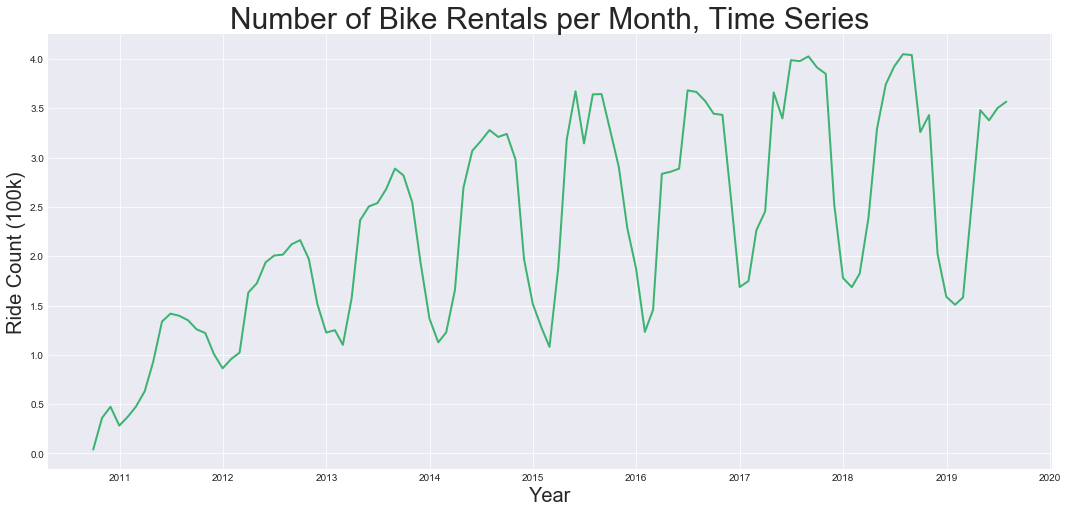

In [146]:
p.initial_plot(bike_df)

Before moving forward, we will divide the data into a 75% training dataset and a 25% testing dataset. We will then graph both to make sure that the split is functional.

In [147]:
train_df, test_df = f.train_split(bike_df)

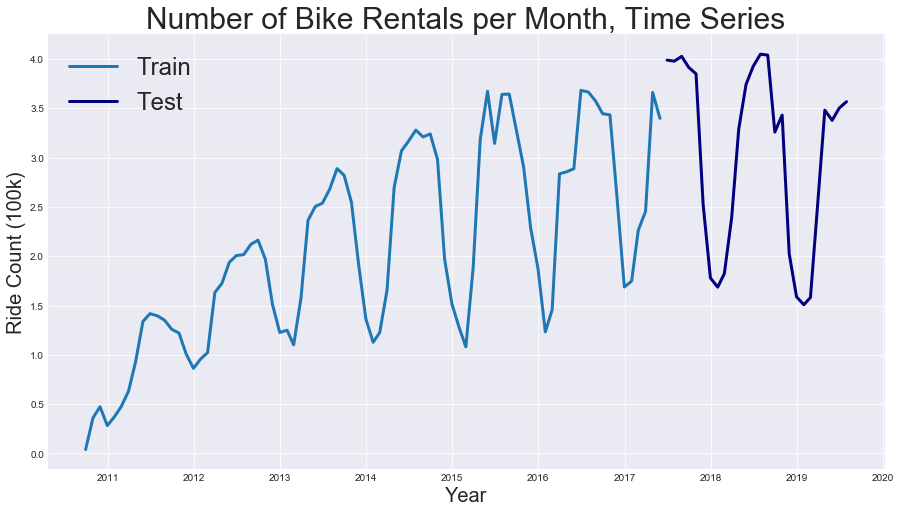

In [148]:
p.split_plot(train_df, test_df)

In order to determine whether there is either a trend or a seasonal fluctuation, we will create a decomposition.

<Figure size 432x288 with 0 Axes>

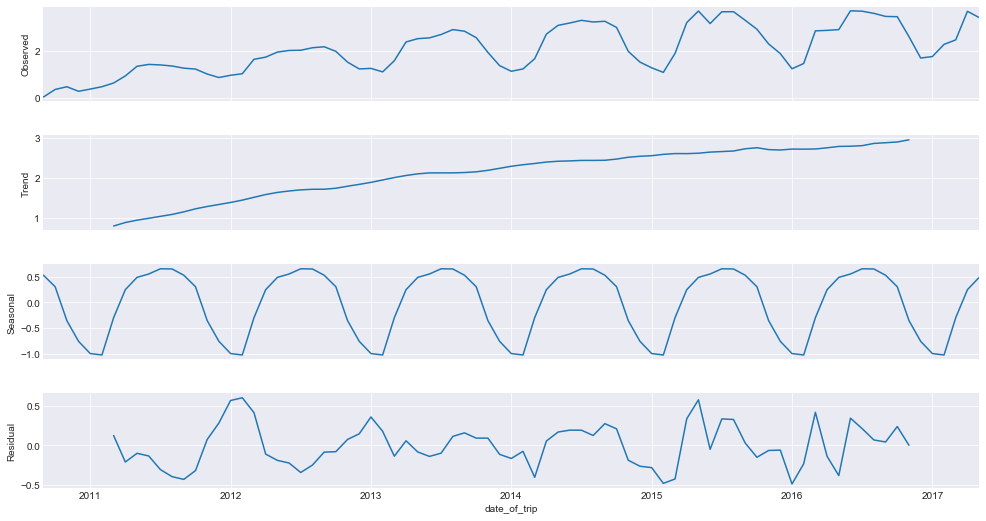

In [149]:
p.decomposition(train_df)

This decomposition suggests the presence not only of overall trends, but of 12-month seasonal trends as well. In order to create our model, we will need to make sure that we create enough regular and seasonal differences in our model to make our data stationary.

## Differencing

We will now perform a preliminary Dickey-Fuller test on our model, in order to prove that our time-series requires differencing to become stationary. This test will take as its null hypothesis that the time-series is not stationary, and will attempt to disprove this null hypothesis. It will also graph the rolling mean and the rolling standard deviation of the time-series.

We will be looking at both the p-value of the test (defining any values above 0.05 as statistically significant) to determine whether the time-series is stationary. We will also be assessing the graphs of the rolling mean and the rolling standard deviations to see if they are stationary.

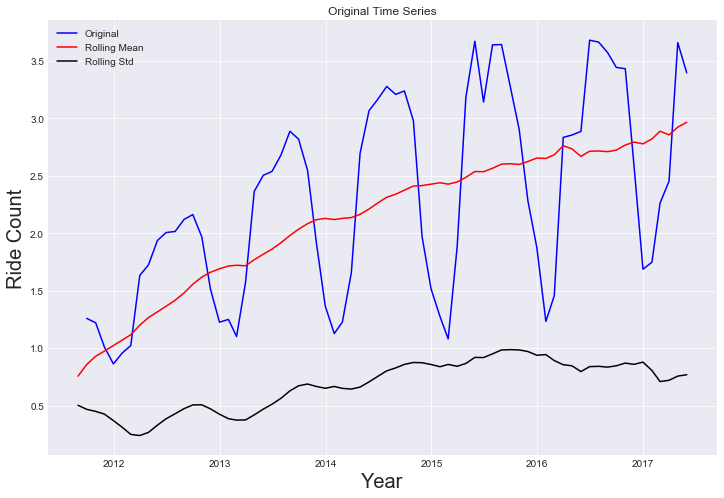

Results of Dickey-Fuller Test:
Test Statistic                 -4.065344
p-value                         0.001104
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [150]:
dt.stationarity_test(train_df)

Although the p-value indicates that the time-series is stationary, the graph of the rolling mean shows a clear trend. We will now try adding a difference of one month.

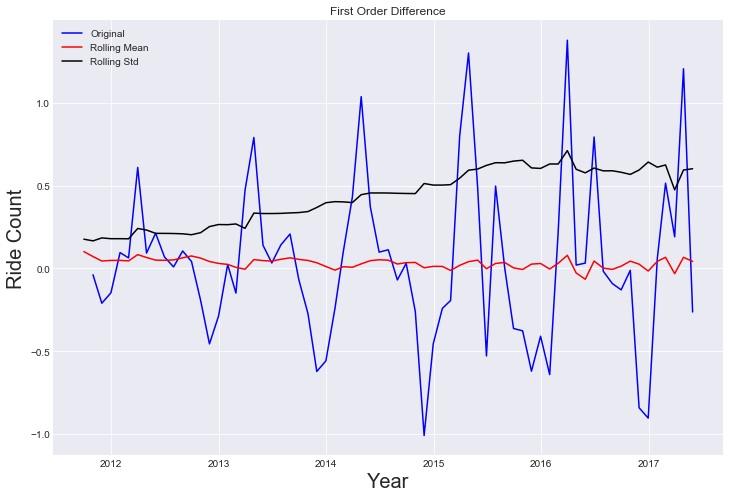

Results of Dickey-Fuller Test:
Test Statistic                 -3.316431
p-value                         0.014160
#Lags Used                     12.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [151]:
dt.stationarity_test(train_df, diff=True)

Although the p-value has increased (potentially due to a slight increase throughout the graph in the rolling standard deviation), there is still less than a 5% chance that the time-series with one difference is not stationary. In addition, the rolling mean has become visibly more stationary. This indicates that we can remove the overall trend by including a single one-month difference in our ARIMA model. Although this could potentially be improved with another one-month difference, since our SARIMA model will likely require a 12-month difference, we will only include a single regular one-month difference at this point.

We will now use the Dickey-Fuller test to determine how many one-month differences our SARIMA model will require. The first test will assess our original data with a 12-month difference added.

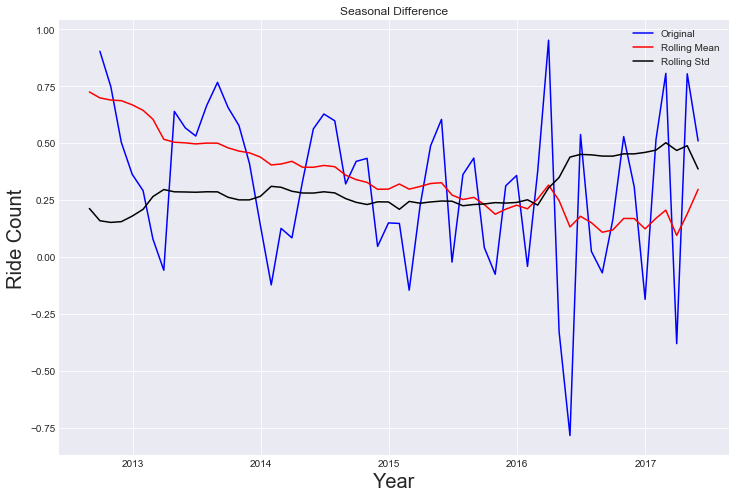

Results of Dickey-Fuller Test:
Test Statistic                 -1.953684
p-value                         0.307243
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [152]:
dt.stationarity_test(train_df, s_diff=True)

The p-value is far above our 5% cut-off rate, indicating that we cannot disprove the null hypothesis. This indicates that even with a 12-month difference, our seasonal data is not stationary. We will now try differencing our original data by one month, and then adding a 12-month difference to this data.

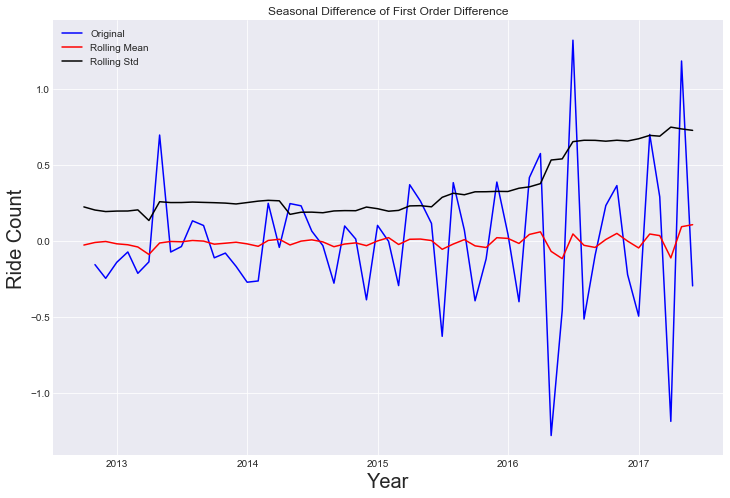

Results of Dickey-Fuller Test:
Test Statistic                -6.093700e+00
p-value                        1.021998e-07
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [153]:
dt.stationarity_test(train_df, diff=True, s_diff=True)

Both the graph and the p-value indicate that when we difference our data by one month, and then add a 12-month seasonal difference, this removes the seasonal fluxuations. We will therefore move forward with the assumption that our ARIMA model requires one difference, and that our SARIMA model with a 12-month seasonal difference also requires a one-month difference.

## Autoregressions (ARs) and Moving Averages (MAs)

We will now determine whether our ARIMA or SARIMA models require any ARs or MAs. We will do this by creating autocorrelation functions (ACFs) and partial-autocorrelation functions (PACFs) for our data.

The ACF and PACF will relate to our data with a one-month difference.

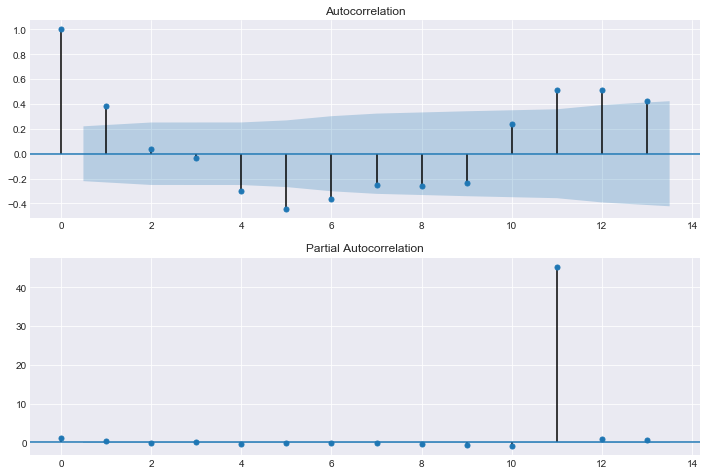

In [154]:
first = f.order_difference(train_df, diff=True, s_diff=False)
p.acf_pacf(first)

Since the first lag of the PACF seems positive, this indicates that our ARIMA model should contain at least one AR. However, since the first lag of the ACF contains a somewhat sharp cutoff, it may also require at least one MA.

In addition, since our seasonal cycle is roughly 12 months, we can look at the 11-13 month lag in the ACF to determine whether our SARIMA model will require at least one seasonal AR. However, the fact that the PACF contains a very sharp drop at the twelve-month lag, this indicates that the model may also require a seasonal MA.

Since it can be difficult to determine the optimal number of ARs and MAs, we will test a number of models, and determine the Means Squared Error (MSE) for each model.

Each model will have a different number of ARs and MAs for its ARIMA and SARIMA parameters. For the ARIMA model, in order to keep multiple ARs and MAs from cancelling out each other, and to avoid overfitting, each ARIMA model we test will have no more than two of each. The ARIMA models tested will be as follows:

(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)


For the SARIMA model, in order to avoid overfitting, we will use no more than two combined SARs and SMAs. The SARIMA models tested will be as follows:

(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)

(1, 1, 0), (1, 1, 0, 12):
Training MSE:  1.11e+09
(1, 1, 0), (2, 1, 0, 12):
Training MSE:  1.11e+09
(1, 1, 0), (1, 1, 1, 12):
Training MSE:  1.11e+09
(2, 1, 0), (1, 1, 0, 12):
Training MSE:  1.02e+09
(2, 1, 0), (2, 1, 0, 12):
Training MSE:  1.02e+09
(2, 1, 0), (1, 1, 1, 12):
Training MSE:  1.01e+09
(1, 1, 1), (1, 1, 0, 12):
Training MSE:  1.07e+09
(1, 1, 1), (2, 1, 0, 12):
Training MSE:  1.08e+09
(1, 1, 1), (1, 1, 1, 12):
Training MSE:  1.11e+09
(2, 1, 1), (1, 1, 0, 12):
Training MSE:  9.92e+08
(2, 1, 1), (2, 1, 0, 12):
Training MSE:  9.89e+08
(2, 1, 1), (1, 1, 1, 12):
Training MSE:  1.00e+09
(1, 1, 2), (1, 1, 0, 12):
Training MSE:  1.06e+09
(1, 1, 2), (2, 1, 0, 12):
Training MSE:  1.06e+09
(1, 1, 2), (1, 1, 1, 12):
Training MSE:  1.08e+09
Best MSE: 9.89e+08
Best Model: (2, 1, 1), (2, 1, 0, 12)


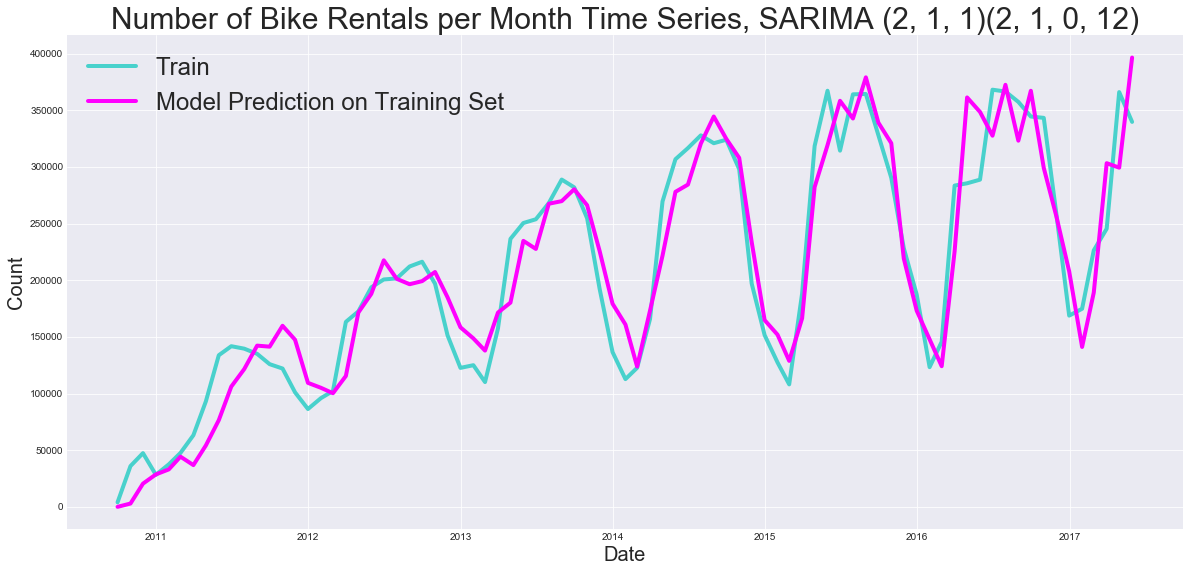

In [208]:
orders = [(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
s_orders = [(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)]
dt.sarima(train_df, orders, s_orders)

Based on this analysis, we're able to determine that a model with a first order of regular differencing, three regular ARs, a twelve-month seasonal differencing for its first order of regular differencing, and one seasonal AR produce the smallest MSE.

Before we accept this result, we want to first check the model summary, to ensure that each AR and MA is statistically significant, and remove any that are not statistically significant.

In [211]:
best = sm.tsa.statespace.SARIMAX(train_df['count'], trend='n',
                                 order=(2, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -802.493
Date:                            Wed, 01 Apr 2020   AIC                           1616.985
Time:                                    22:18:12   BIC                           1630.302
Sample:                                09-30-2010   HQIC                          1622.262
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5969      0.246     -2.430      0.015      -1.078      -0.115
ar.L2         -0.5700      0.126     -4.520      0.000      -0.817      -0.323
ma.L1          0.2409      0.312      0.771      0.441      -0.371       0.853
ar.S.L12      -0.1905      0.124     -1.540      0.124      -0.433       0.052
ar.S.L24      -0.0564      0.158     -0.357      0.721      -0.366       0.253
sigma2      1.027e+09   4.45e-11   2.31e+19      0.000    1.03e+09    1.03e+09
===================================================================================
Ljung-Box (Q):                       52.08   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.10   Prob(JB):                         0.52
Heteroskedasticity (H):               2.29   Skew:                             0.08
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+35. Standard errors may be unstable.
"""

Based on this summary, we can determine that the first two regular autoregressions are statistically significant. However, the moving average, and the seasonal autoregressions are not statistically significant, indicating that our model would be improved by removing them. For this reason, we will keep two autoregressions, and remove the rest of the autoregressions and moving averages.

## Initial Modeling Results

The (2, 1, 0), (0, 1, 0, 12) model has the lowest MSE for the training data while maintaining statistical significance for each SARIMA regulator, indicating that this is the model that we should use. Based on this result, we will use the model to determine the MSE for the test dataset. Then, we will create a 12-month forecast of the original dataset, including an 80% prediction interval.

First, we will take a look at residual normality to make sure this model is valid. 

In [204]:
best = sm.tsa.statespace.SARIMAX(train_df['count'], trend='n',
                                 order=(2, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()

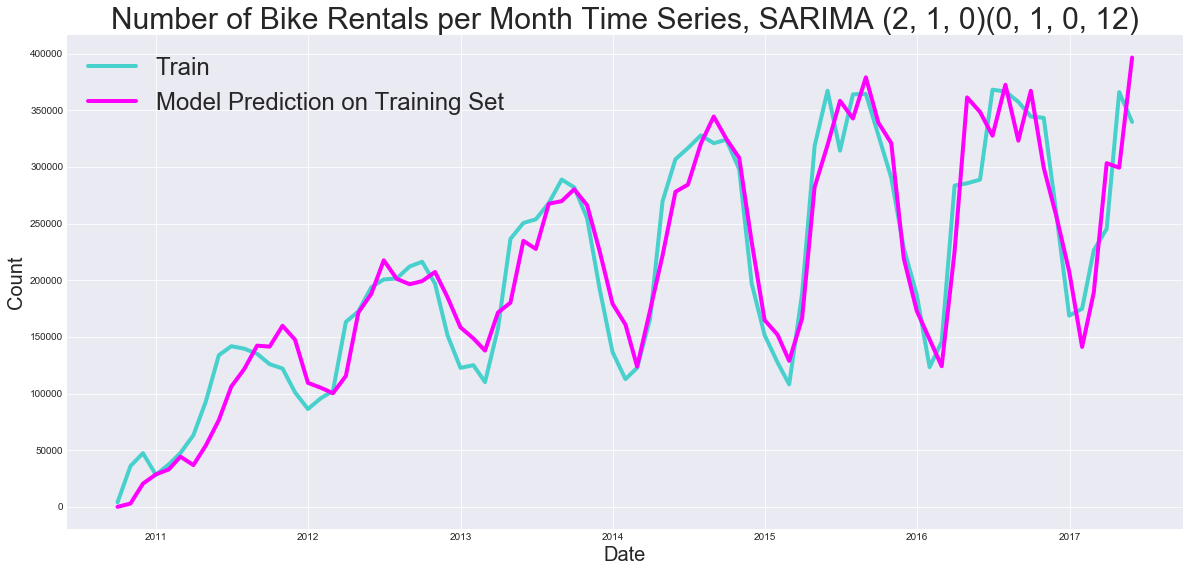

In [212]:
p.prediction_plot(best, train_df, orders=(2, 1, 0), s_orders=(0, 1, 0, 12), test=False, var='count')

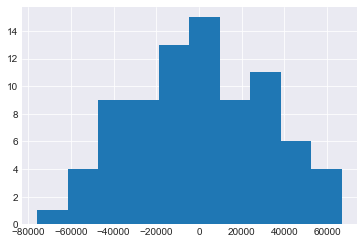

In [213]:
best.resid.hist()

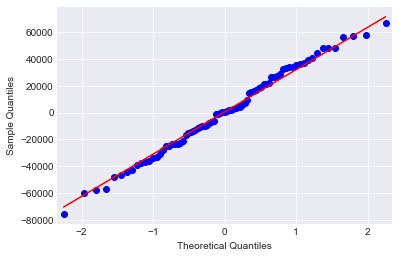

In [214]:
qqplot(best.resid, line='s');

Based on this, the residuals appear normally distributed. Next, we will graph both the training and test data, and we will determine the MSE for the test data.

Training MSE:  9.89e+08
Testing MSE:  2.56e+09


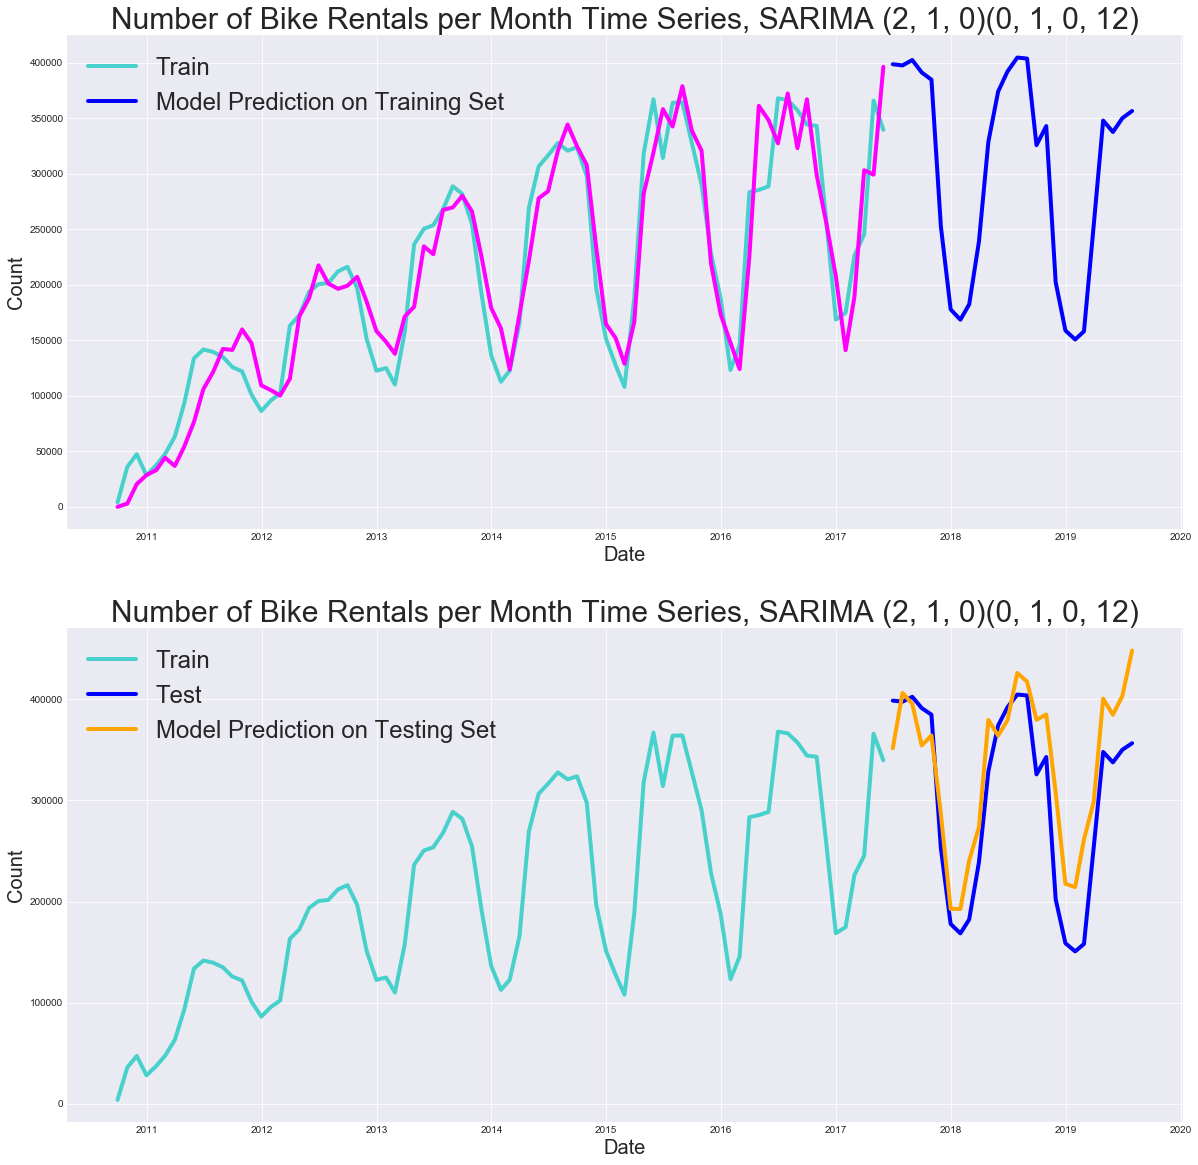

In [215]:
dt.compare_mse(best, bike_df, test=True, return_val=False)
p.prediction_plot(best, bike_df, orders=(2, 1, 0), s_orders=(0, 1, 0, 12), test=True)

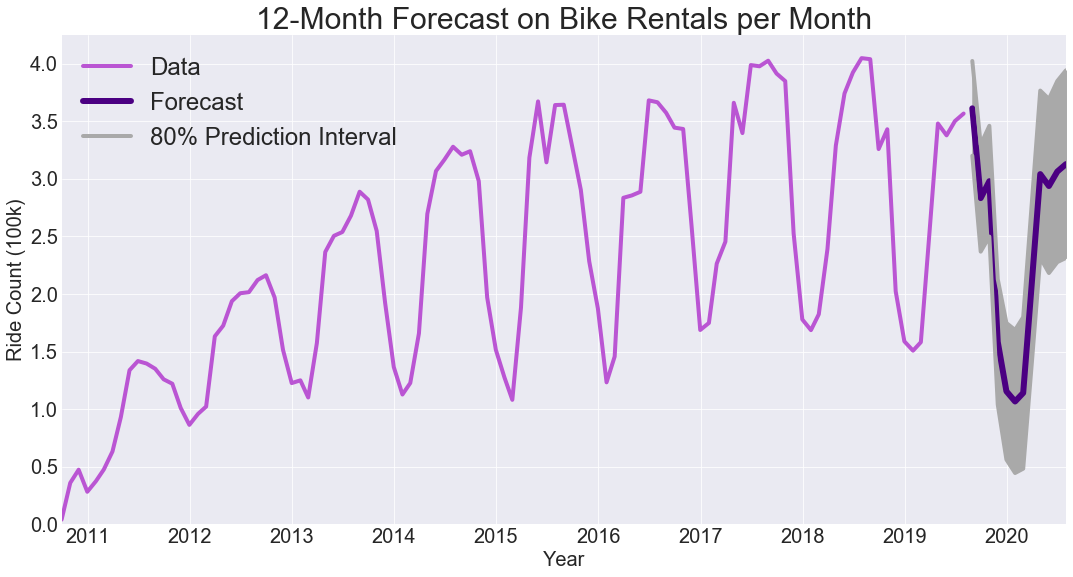

In [216]:
best = sm.tsa.statespace.SARIMAX(bike_df['count'], trend='n', order=(2, 1, 0), seasonal_order=(0, 1, 0, 12)).fit()
p.forecast_plot(best, bike_df, 12)

From this, we can see that the MSE increases quite a bit. In addition, we can also see from our 80% prediction interval in our test dataset that 

From this, we can see that there is still a lot of variance in the prediction interval. A logical next step is to consider trends in rentals grouped as either casual or member rentals. From this point on, we will divide the dataset into 'Member' and 'Casual' (one-time bicycle renters).

## Member/Casual Rental Breakdown

The following functions and lines of code re-clean the data, this time breaking the datasets down according to member vs. casual rentals per month. We will now download data grouped by membership, graph it, and split it into the 75%-25% train-test group.

In [132]:
bike_rental_type = f.master_breakdown()

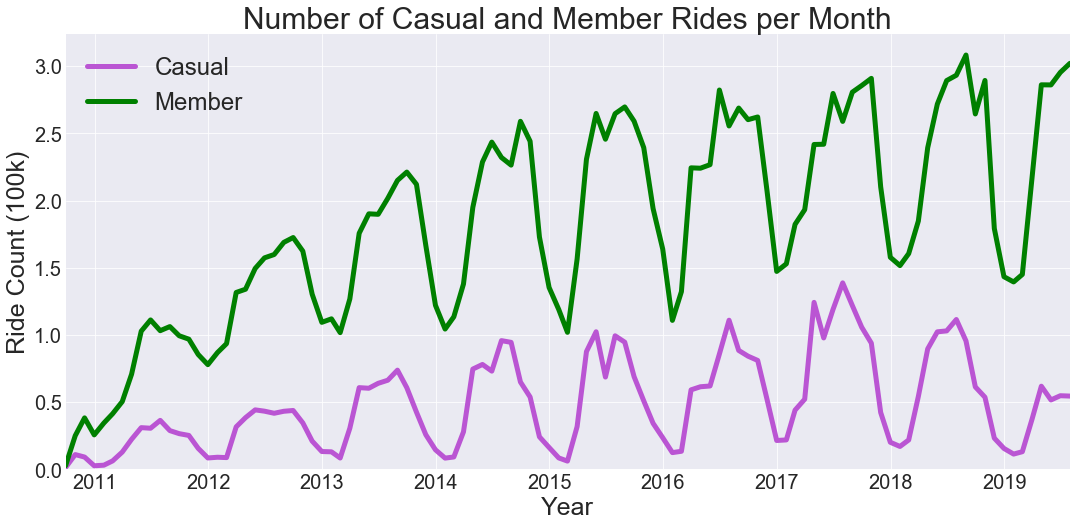

In [133]:
p.initial_breakdown_graph(bike_rental_type)

In [134]:
breakdown_train, breakdown_test = f.train_split(
    bike_rental_type, train_percent=.75)

In order to find the best models for each, we need to first determine the ARIMA and SARIMA parameters for each data group.

## Member dataset

We will start with the "Member" dataset. We will first determine the number of orders of differencing it requires.

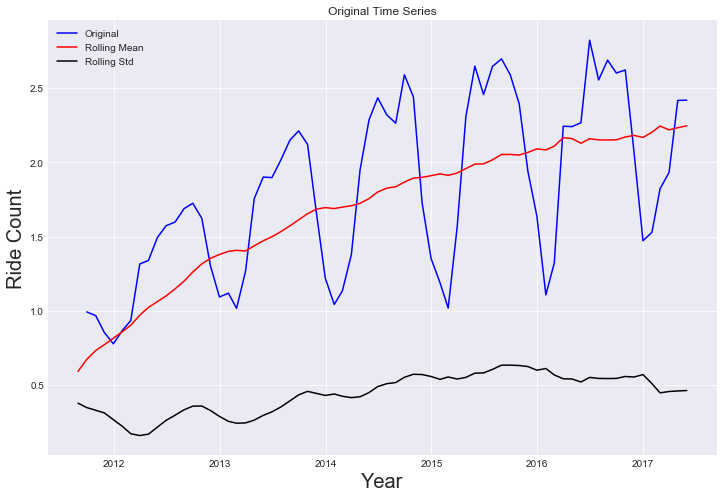

Results of Dickey-Fuller Test:
Test Statistic                 -4.835134
p-value                         0.000047
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [135]:
dt.stationarity_test(breakdown_train, var='member')

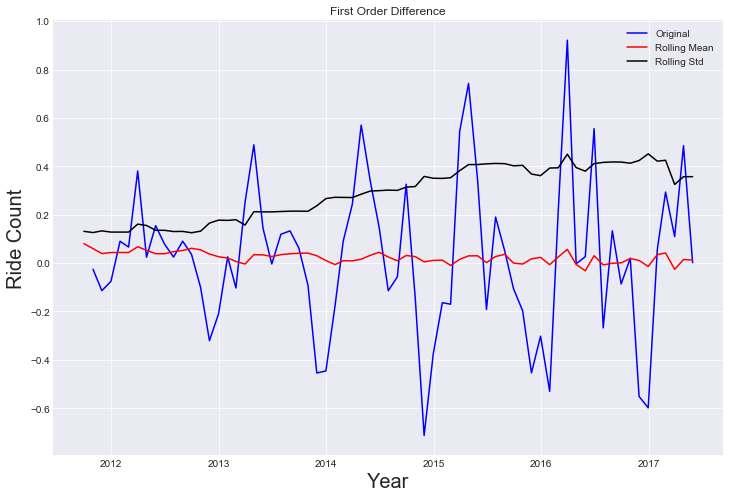

Results of Dickey-Fuller Test:
Test Statistic                 -3.395180
p-value                         0.011124
#Lags Used                     11.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [136]:
dt.stationarity_test(breakdown_train, var='member', diff=True)

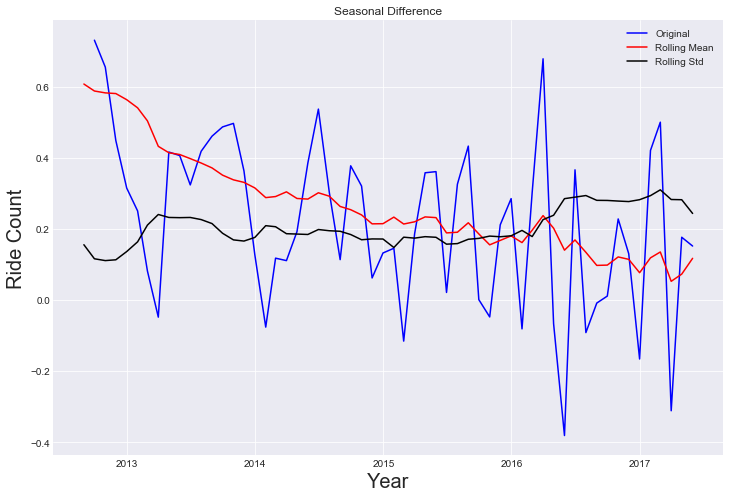

Results of Dickey-Fuller Test:
Test Statistic                 -1.810303
p-value                         0.375359
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [137]:
dt.stationarity_test(breakdown_train, var='member', s_diff=True)

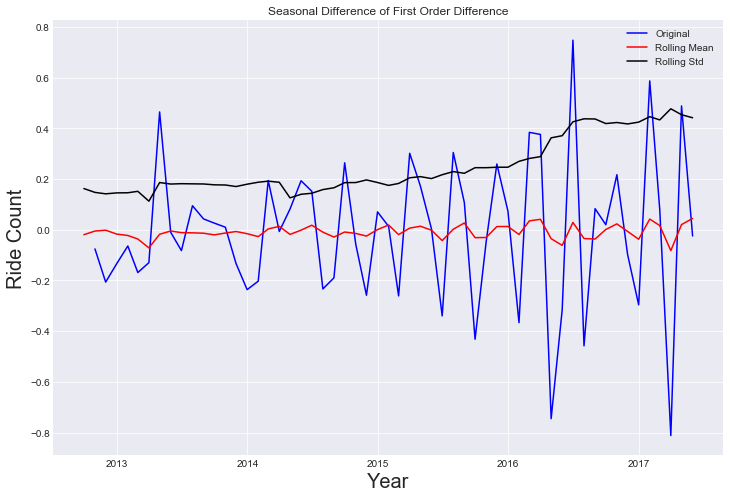

Results of Dickey-Fuller Test:
Test Statistic                -6.284988e+00
p-value                        3.716892e-08
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [138]:
dt.stationarity_test(breakdown_train, var='member', s_diff=True, diff=True)

Like the prior model, this indicates that the "Members" dataset requires one order of regular differencing, and one order of 12-month seasonal differencing following this differencing.

We will now look at the PACF and ACF.

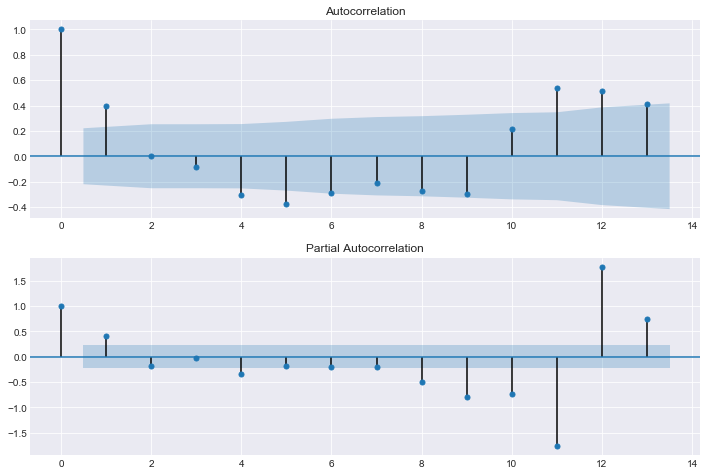

In [139]:
first = f.order_difference(breakdown_train, var='member', diff=True, s_diff=False)
p.acf_pacf(first, var='member')

As with the prior analysis, this dataset has a positive first difference in its PACF, indicating it will require at least one AR. In addition, the positive autocorrelation surrounding the 12-month seasonal difference indicates that it will require at least one SACF as well.

In order to verify the best model, we will use the prior function to determine the optimal ARIMA and SARIMA parameters. We will test the same ARIMA/SARIMA combinations as before.

(1, 1, 0), (1, 1, 0, 12):
Training MSE:  5.03e+08
(1, 1, 0), (2, 1, 0, 12):
Training MSE:  5.00e+08
(1, 1, 0), (1, 1, 1, 12):
Training MSE:  4.99e+08
(2, 1, 0), (1, 1, 0, 12):
Training MSE:  4.58e+08
(2, 1, 0), (2, 1, 0, 12):
Training MSE:  4.57e+08
(2, 1, 0), (1, 1, 1, 12):
Training MSE:  4.56e+08
(1, 1, 1), (1, 1, 0, 12):
Training MSE:  4.94e+08
(1, 1, 1), (2, 1, 0, 12):
Training MSE:  4.94e+08
(1, 1, 1), (1, 1, 1, 12):
Training MSE:  4.93e+08
(2, 1, 1), (1, 1, 0, 12):
Training MSE:  4.46e+08
(2, 1, 1), (2, 1, 0, 12):
Training MSE:  4.43e+08
(2, 1, 1), (1, 1, 1, 12):
Training MSE:  4.44e+08
(1, 1, 2), (1, 1, 0, 12):
Training MSE:  4.83e+08
(1, 1, 2), (2, 1, 0, 12):
Training MSE:  4.81e+08
(1, 1, 2), (1, 1, 1, 12):
Training MSE:  4.81e+08
Best MSE: 4.43e+08
Best Model: (2, 1, 1), (2, 1, 0, 12)


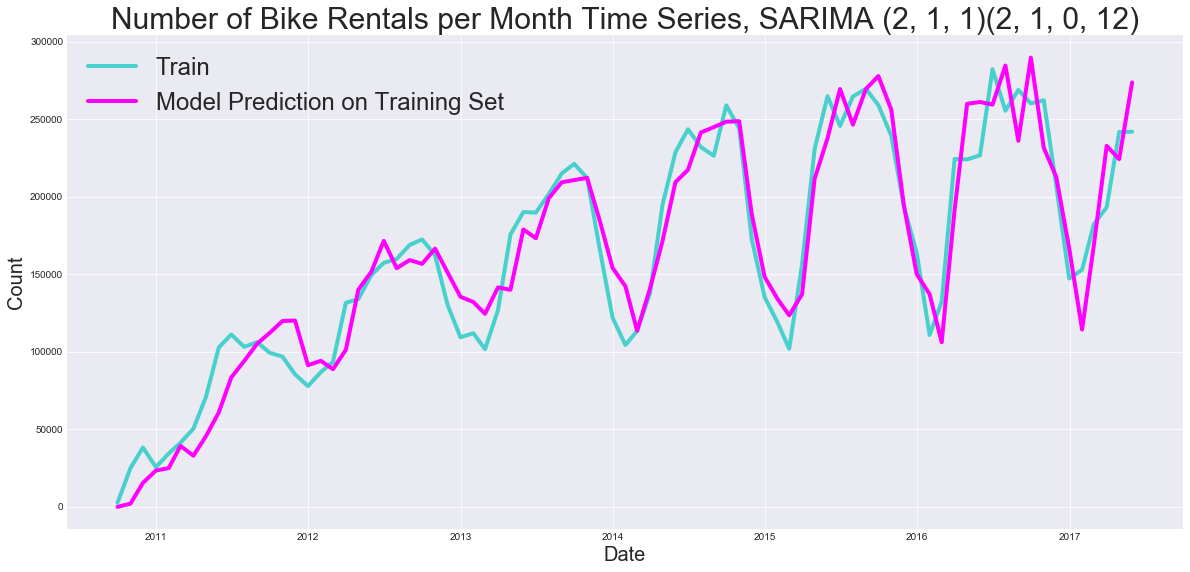

In [140]:
orders = [(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
s_orders = [(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)]
dt.sarima(breakdown_train, orders, s_orders, var='member')

From this, we can determine that for the "Member" dataset, we wil be using a SARIMA model with the parameters
(2, 1, 1) (2, 1, 0, 12), as we used for the prior model.

In [197]:
best = sm.tsa.statespace.SARIMAX(breakdown_train['member'], trend='n',
                                 order=(2, 1, 0),
                                 seasonal_order=(0, 1, 0, 12)).fit()
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -775.270
Date:                            Wed, 01 Apr 2020   AIC                           1556.540
Time:                                    22:12:31   BIC                           1563.199
Sample:                                09-30-2010   HQIC                          1559.179
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4068      0.079     -5.136      0.000      -0.562      -0.252
ar.L2         -0.5807      0.081     -7.137      0.000      -0.740      -0.421
sigma2      4.456e+08   1.32e-11   3.37e+19      0.000    4.46e+08    4.46e+08
===================================================================================
Ljung-Box (Q):                       48.16   Jarque-Bera (JB):                 2.92
Prob(Q):                              0.18   Prob(JB):                         0.23
Heteroskedasticity (H):               1.76   Skew:                             0.04
Prob(H) (two-sided):                  0.18   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.63e+35. Standard errors may be unstable.
"""

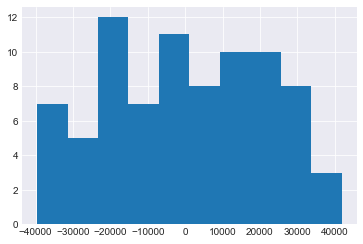

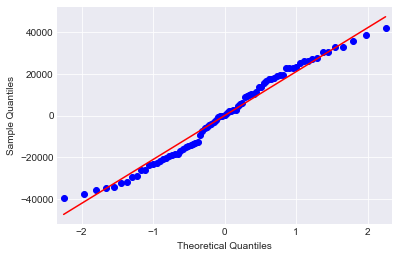

In [141]:
best.resid.hist()
qqplot(best.resid, line='s');

Based on this, although the "Member" residuals appear slightly less normally distributed than the prior dataset, they are still within an acceptable range. Next, we will graph both the "Member" training and test data, and we will determine the MSE for the test data.

Training MSE:  4.43e+08
Testing MSE:  5.51e+08


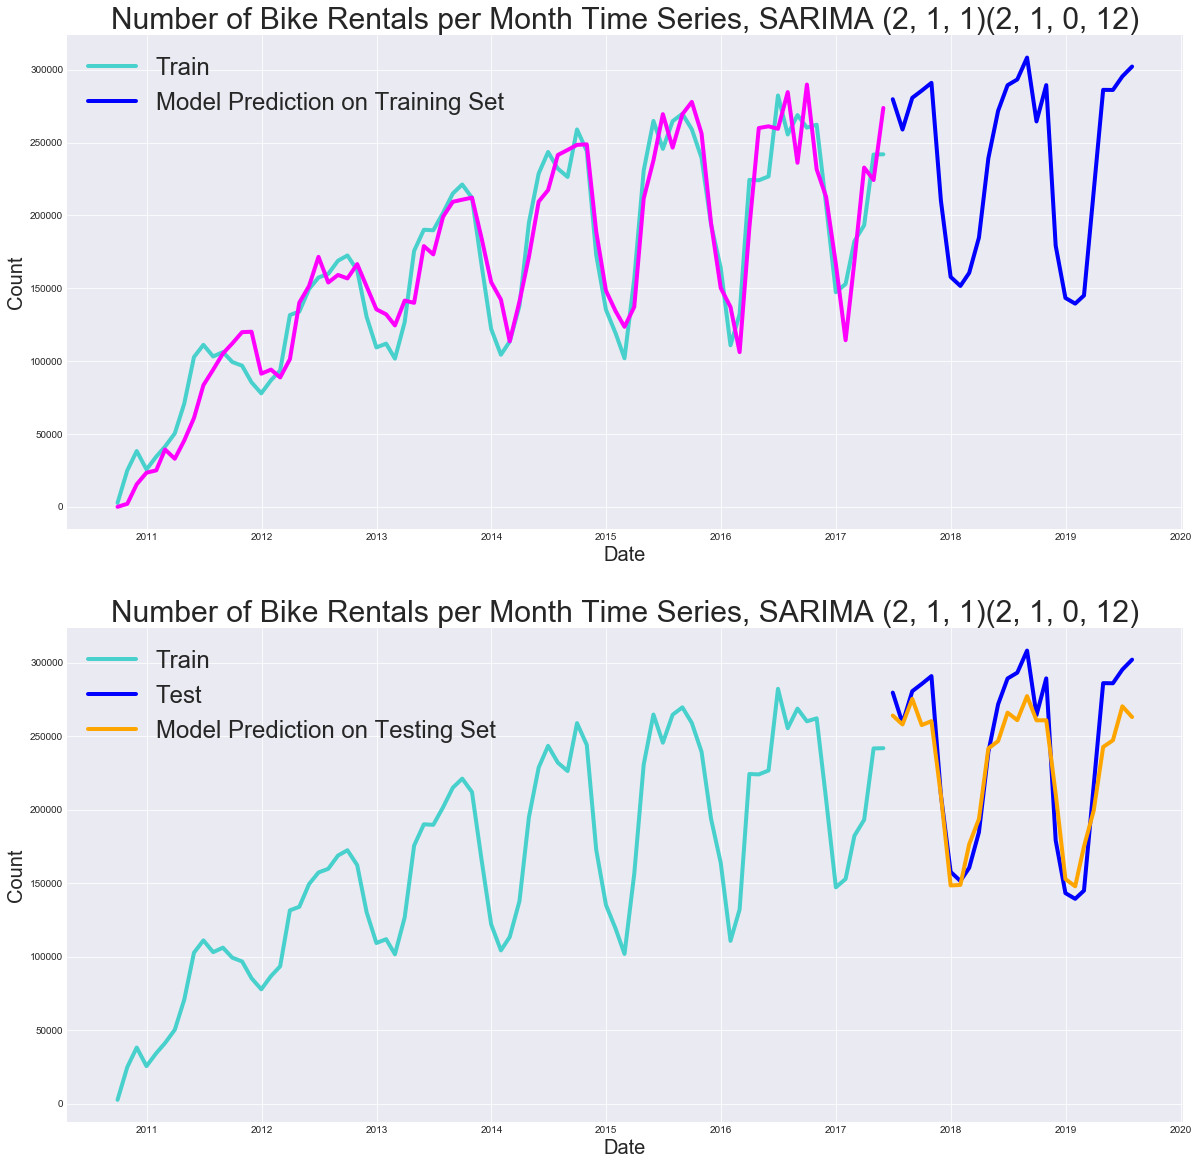

In [159]:
dt.compare_mse(best, bike_rental_type, test=True, return_val=False, var='member')
p.prediction_plot(best, bike_rental_type, orders=(2, 1, 1), s_orders=(2, 1, 0, 12), test=True, var='member')

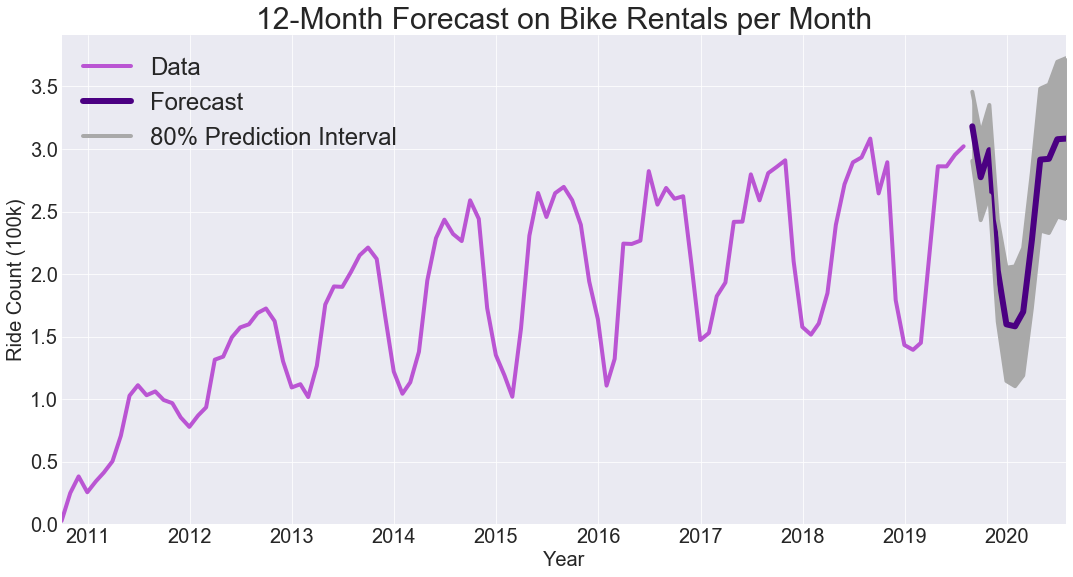

In [175]:
best = sm.tsa.statespace.SARIMAX(bike_rental_type['member'], trend='n',
                                 order=(2, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()
p.forecast_plot(best, bike_rental_type, 12, var='member')

In [177]:
best = sm.tsa.statespace.SARIMAX(bike_rental_type['member'], trend='n',
                                 order=(2, 1, 0), seasonal_order=(1, 1, 0, 12)).fit()
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                  107
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1070.869
Date:                            Wed, 01 Apr 2020   AIC                           2149.738
Time:                                    22:06:11   BIC                           2159.911
Sample:                                09-30-2010   HQIC                          2153.847
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3325      0.089     -3.738      0.000      -0.507      -0.158
ar.L2         -0.4240      0.094     -4.533      0.000      -0.607      -0.241
ar.S.L12      -0.1855      0.137     -1.359      0.174      -0.453       0.082
sigma2      4.586e+08   1.67e-11   2.74e+19      0.000    4.59e+08    4.59e+08
===================================================================================
Ljung-Box (Q):                       65.68   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.01   Prob(JB):                         0.44
Heteroskedasticity (H):               1.57   Skew:                             0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+35. Standard errors may be unstable.
"""

Based on this model, we can see that when we isolate the "Member" rentals, we can see that the test MSE is reduced, as is the 80% Prediction Interval. This indicates that the dataset 

Orders: (2, 1, 0). Seasonal Orders: (0, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -775.270
Date:                            Wed, 30 Oct 2019   AIC                           1556.540
Time:                                    19:07:31   BIC                           1563.199
Sample:                                09-30-2010   HQIC                          1559.179
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4068      0.079     -5.136      0.000      -0.5

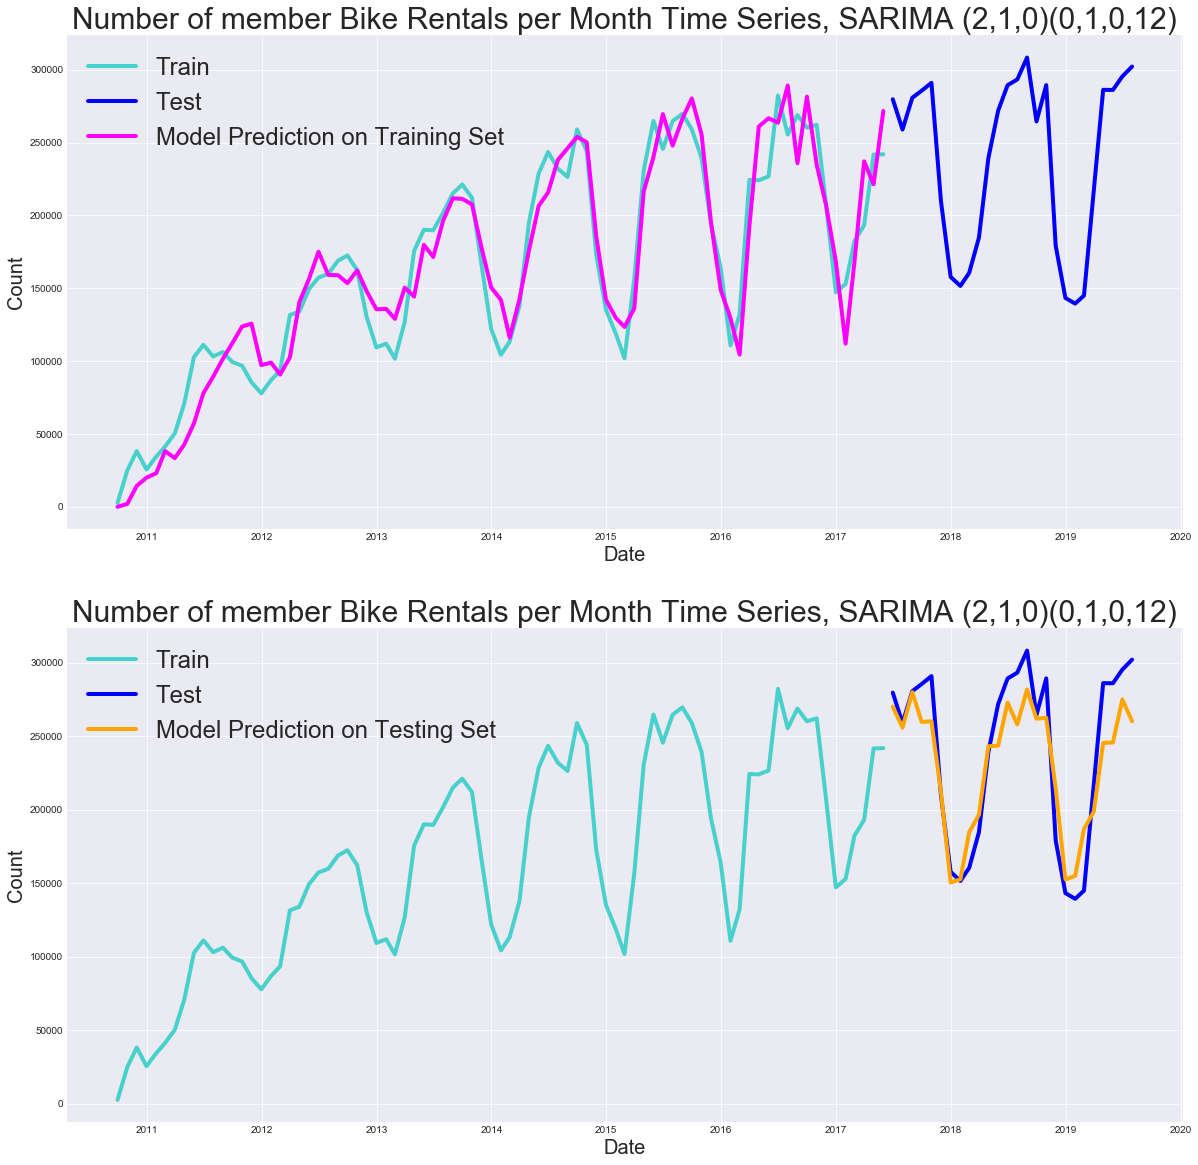

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -748.361
Date:                            Wed, 30 Oct 2019   AIC                           1502.721
Time:                                    19:07:32   BIC                           1509.380
Sample:                                09-30-2010   HQIC                          1505.360
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5329      0.075     -7.103      0.000      -0.680      -0.386
ar.L2         -0.4762      0.112   

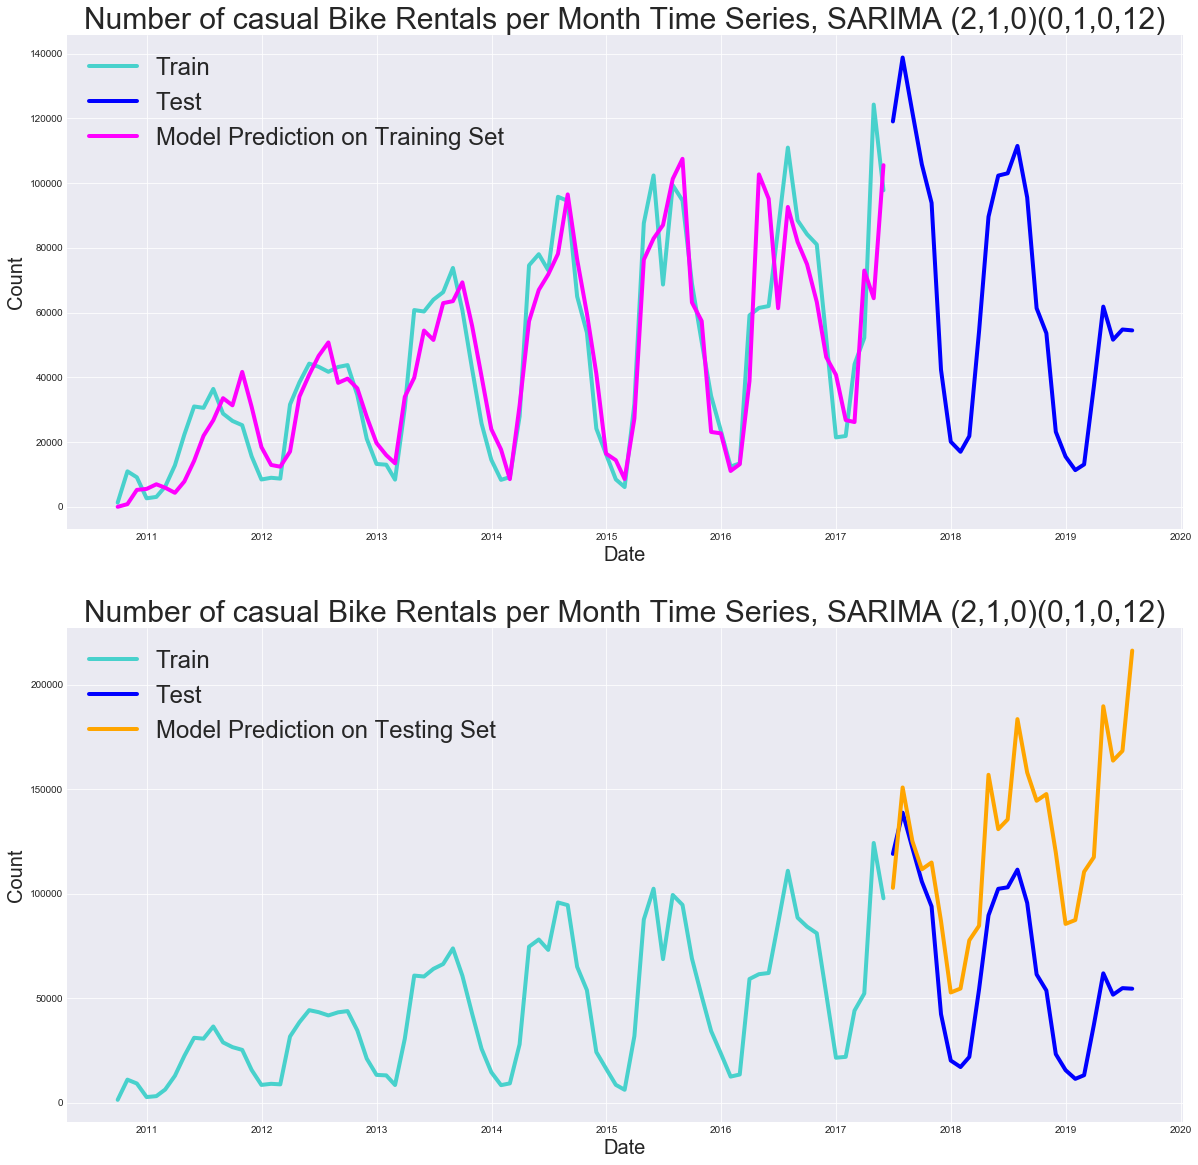

Orders: (2, 1, 0). Seasonal Orders: (1, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -775.042
Date:                            Wed, 30 Oct 2019   AIC                           1558.085
Time:                                    19:07:33   BIC                           1566.963
Sample:                                09-30-2010   HQIC                          1561.603
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3740      0.091     -4.116      0.000      -0.5

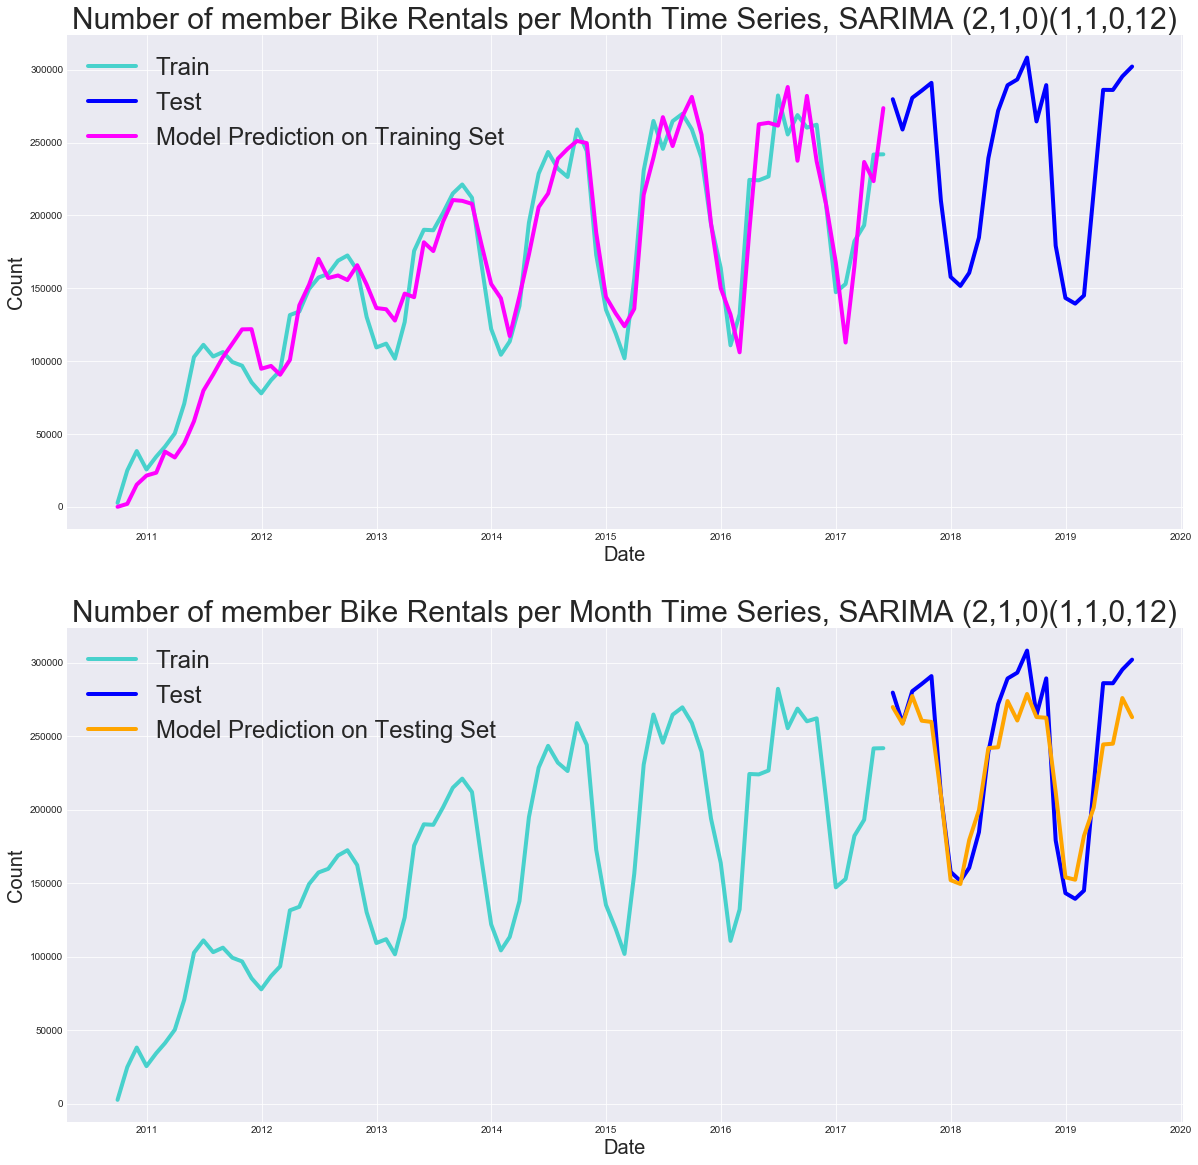

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -746.108
Date:                            Wed, 30 Oct 2019   AIC                           1500.216
Time:                                    19:07:34   BIC                           1509.094
Sample:                                09-30-2010   HQIC                          1503.733
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4677      0.099     -4.744      0.000      -0.661      -0.274
ar.L2         -0.3839      0.118   

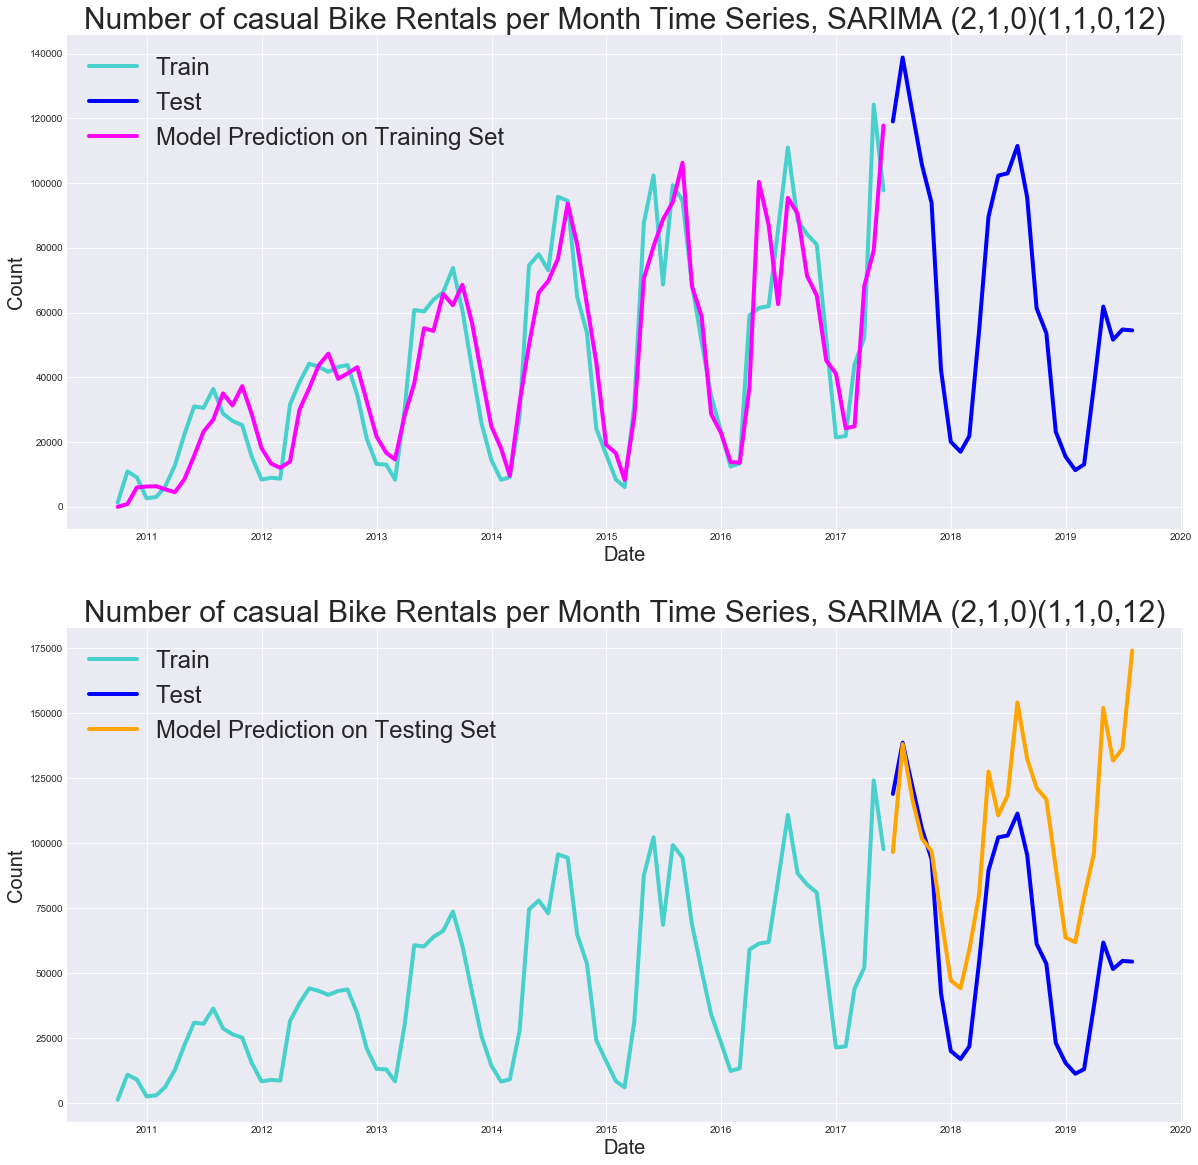

Orders: (2, 1, 0). Seasonal Orders: (0, 1, 1, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -774.995
Date:                            Wed, 30 Oct 2019   AIC                           1557.991
Time:                                    19:07:34   BIC                           1566.869
Sample:                                09-30-2010   HQIC                          1561.509
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3665      0.092     -3.980      0.000      -0.5

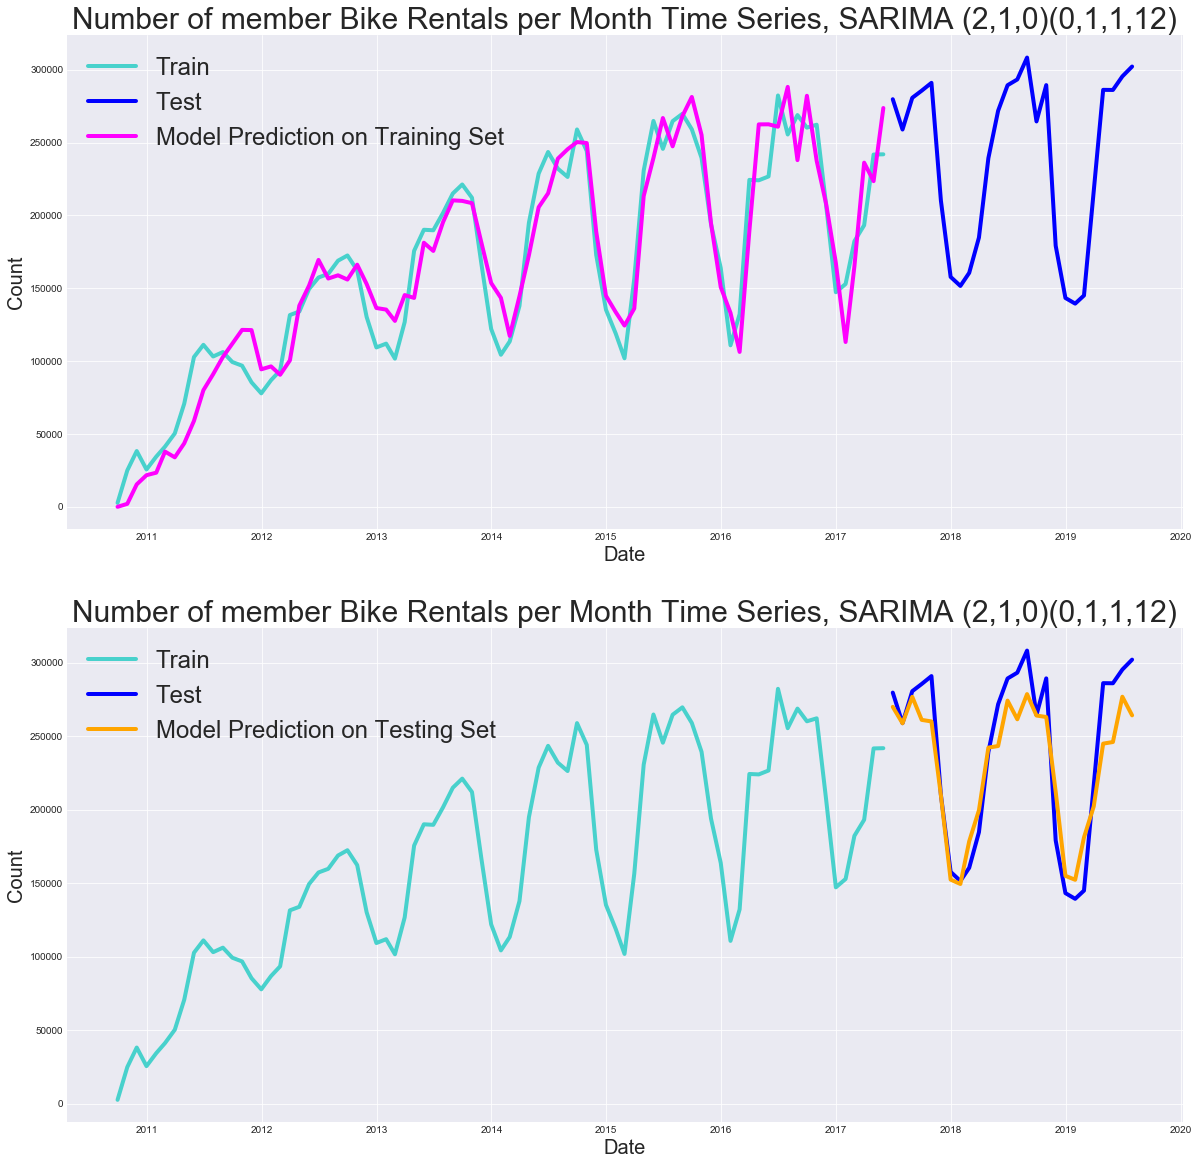

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -746.437
Date:                            Wed, 30 Oct 2019   AIC                           1500.875
Time:                                    19:07:36   BIC                           1509.753
Sample:                                09-30-2010   HQIC                          1504.393
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4609      0.105     -4.388      0.000      -0.667      -0.255
ar.L2         -0.3959      0.120   

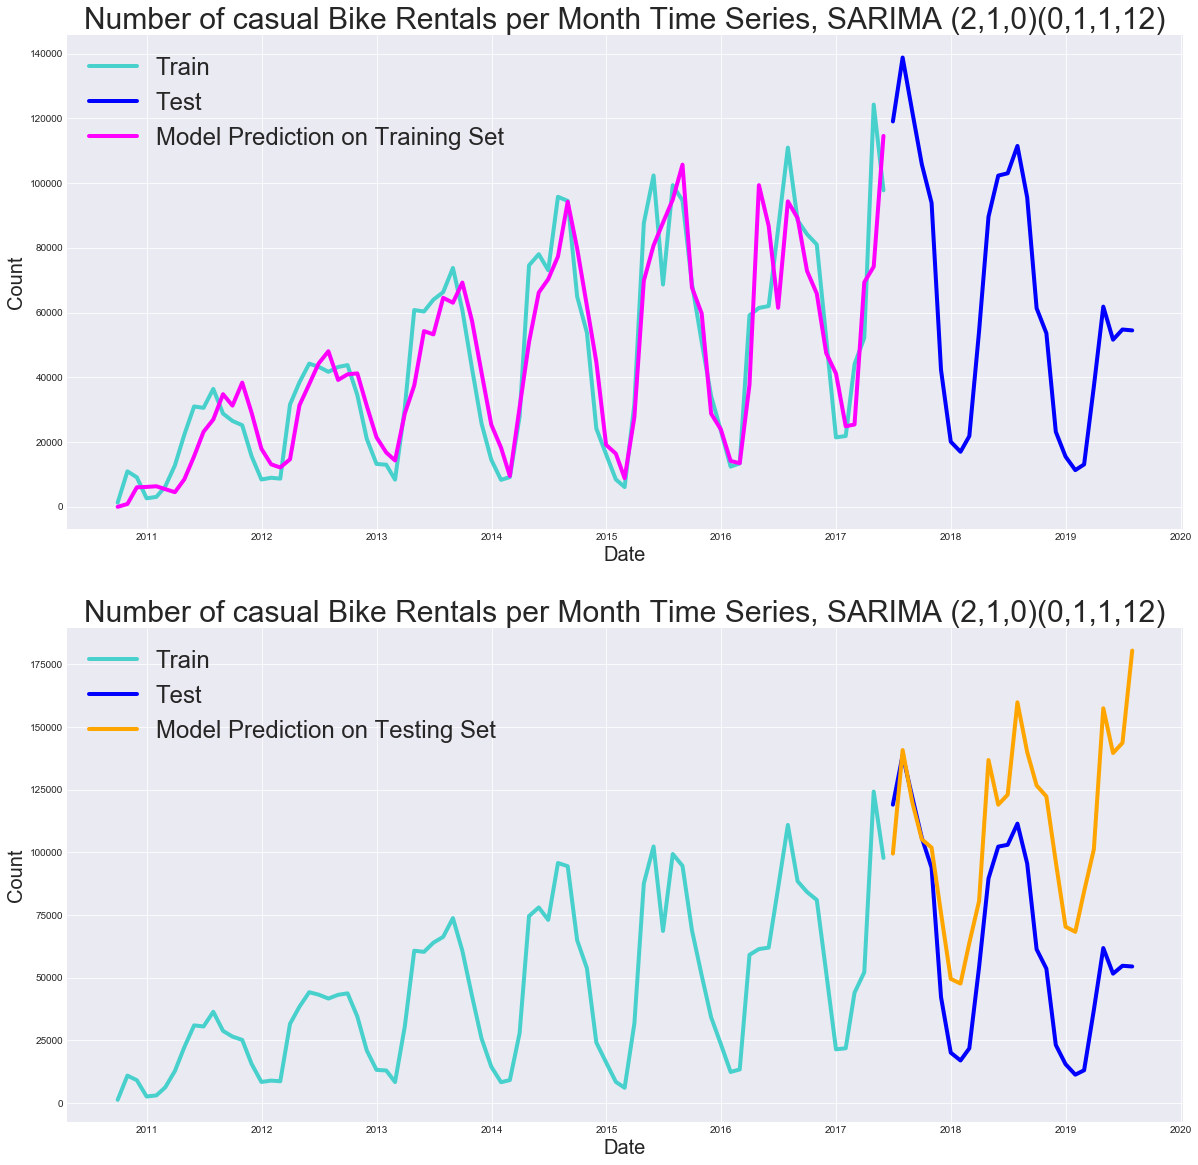

Orders: (2, 1, 1). Seasonal Orders: (0, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -775.025
Date:                            Wed, 30 Oct 2019   AIC                           1558.050
Time:                                    19:07:37   BIC                           1566.928
Sample:                                09-30-2010   HQIC                          1561.568
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5009      0.154     -3.251      0.001      -0.8

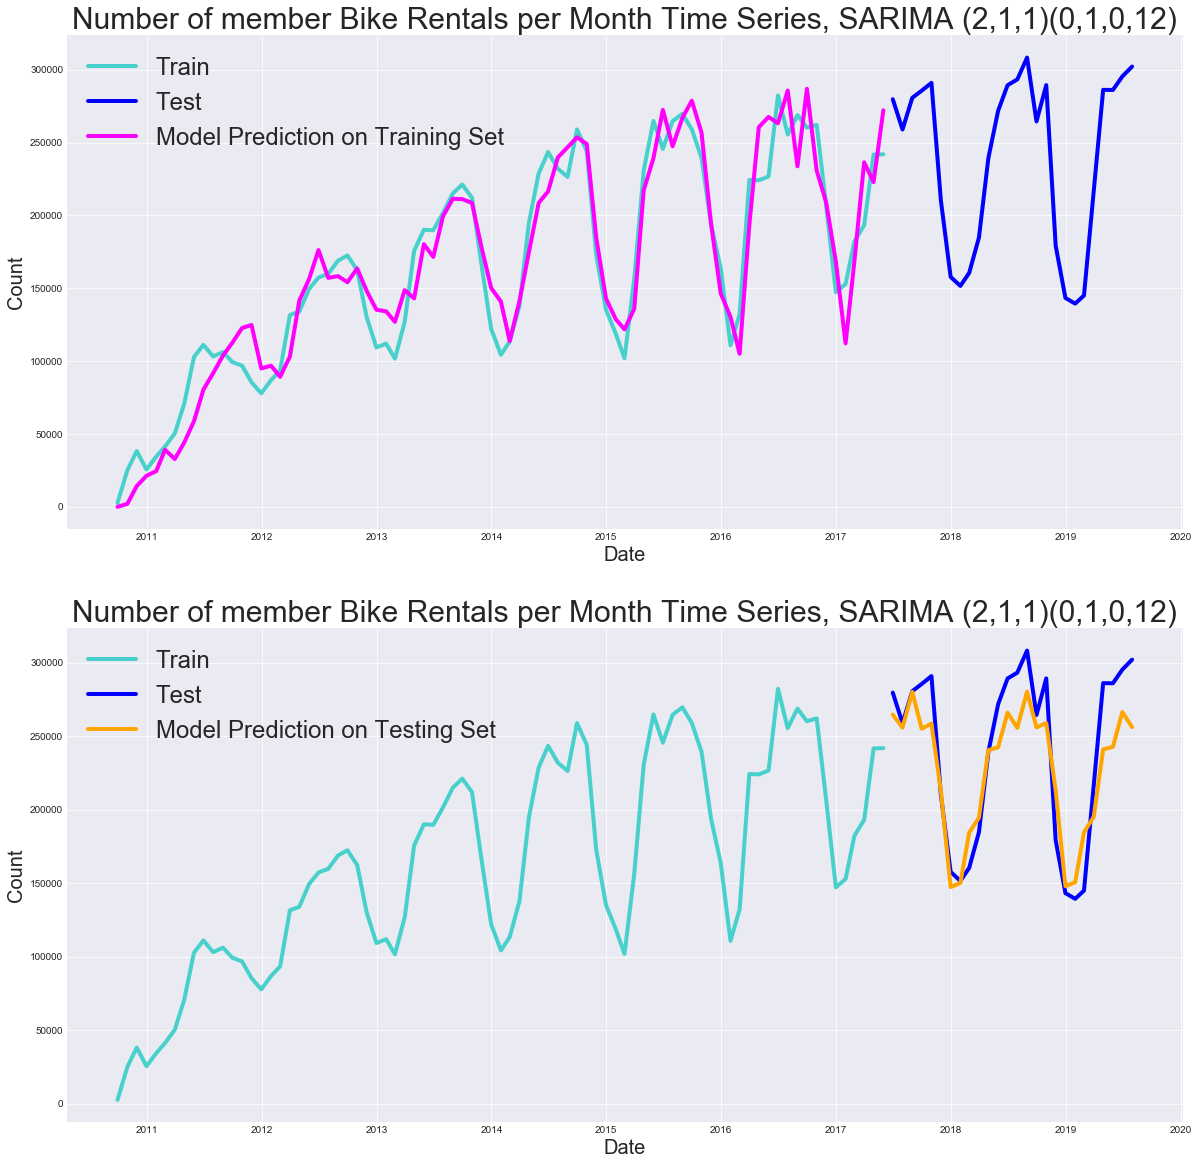

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -748.350
Date:                            Wed, 30 Oct 2019   AIC                           1504.699
Time:                                    19:07:38   BIC                           1513.577
Sample:                                09-30-2010   HQIC                          1508.217
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4952      0.313     -1.581      0.114      -1.109       0.119
ar.L2         -0.4600      0.197   

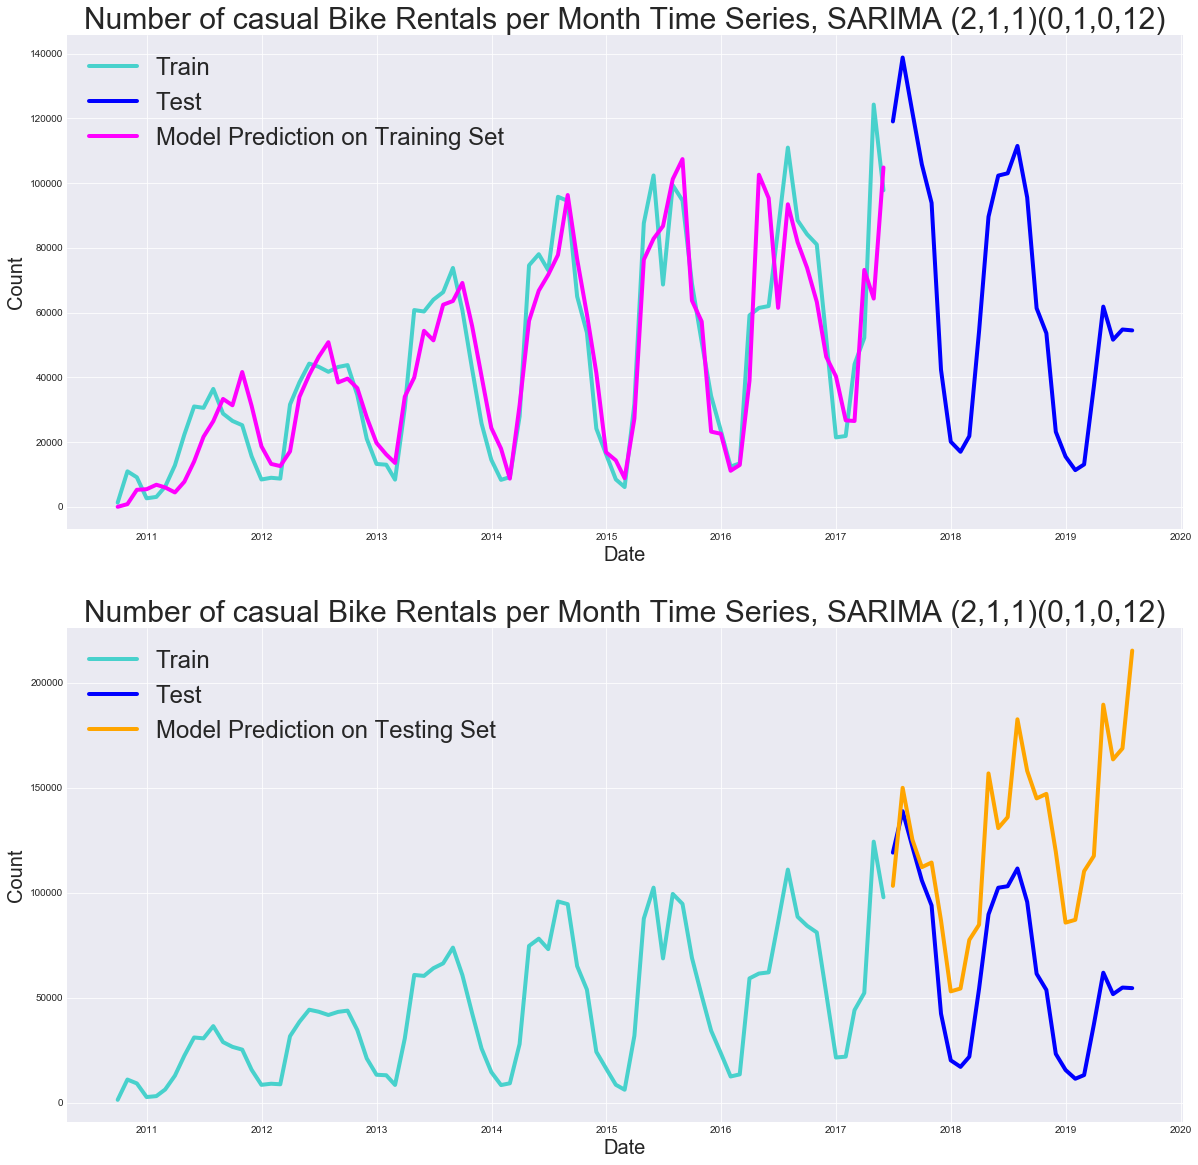

Orders: (2, 1, 1). Seasonal Orders: (1, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -774.666
Date:                            Wed, 30 Oct 2019   AIC                           1559.333
Time:                                    19:07:39   BIC                           1570.430
Sample:                                09-30-2010   HQIC                          1563.730
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5121      0.181     -2.829      0.005      -0.8

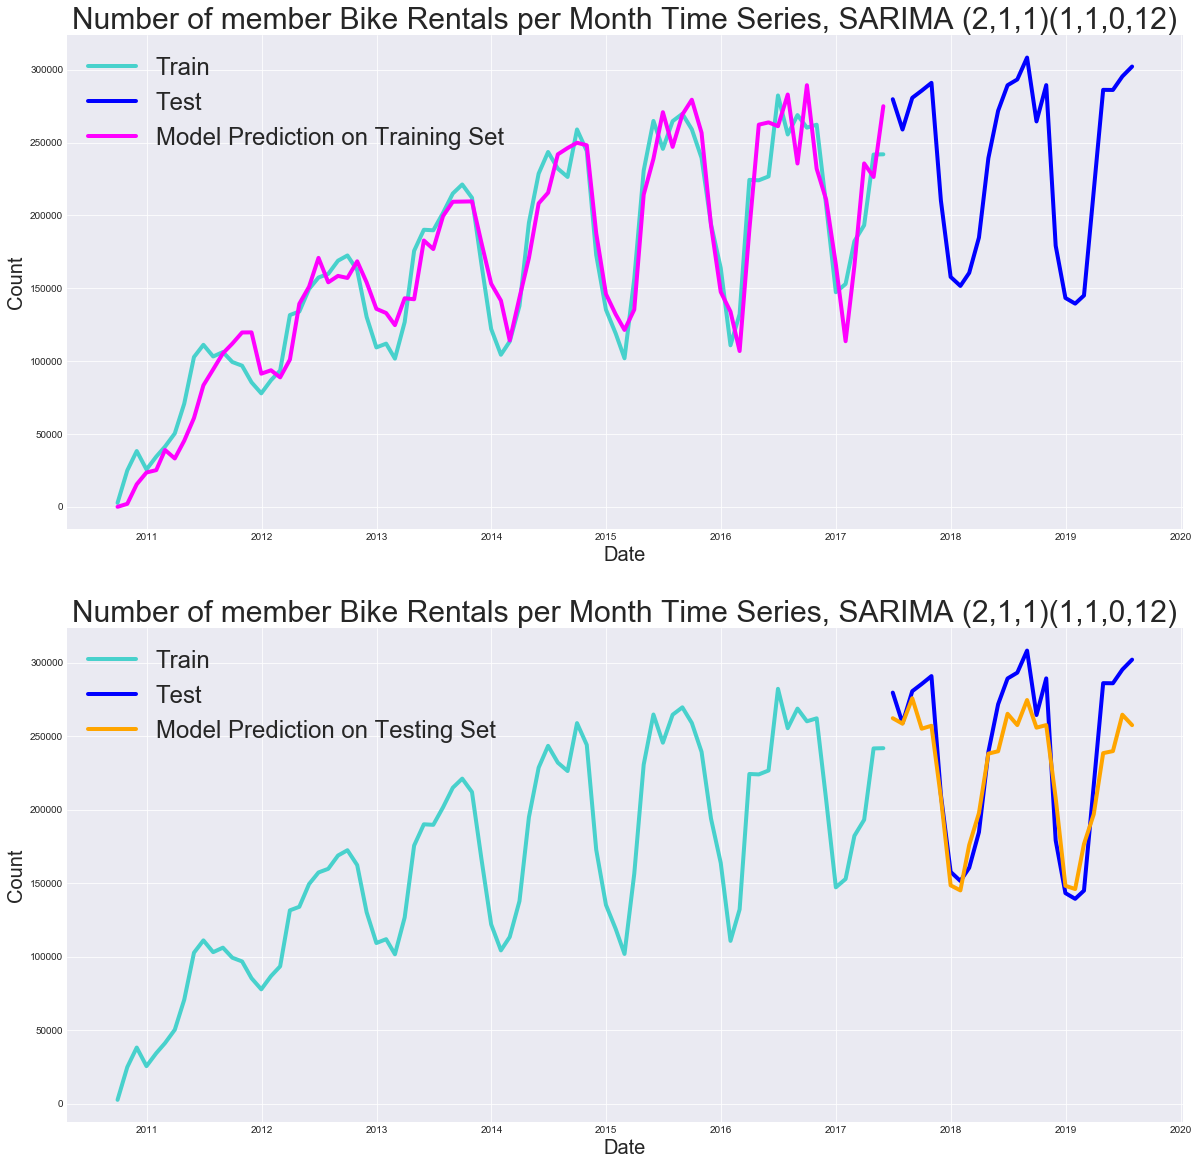

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -746.151
Date:                            Wed, 30 Oct 2019   AIC                           1502.302
Time:                                    19:07:40   BIC                           1513.400
Sample:                                09-30-2010   HQIC                          1506.699
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4825      0.392     -1.232      0.218      -1.250       0.285
ar.L2         -0.3897      0.199   

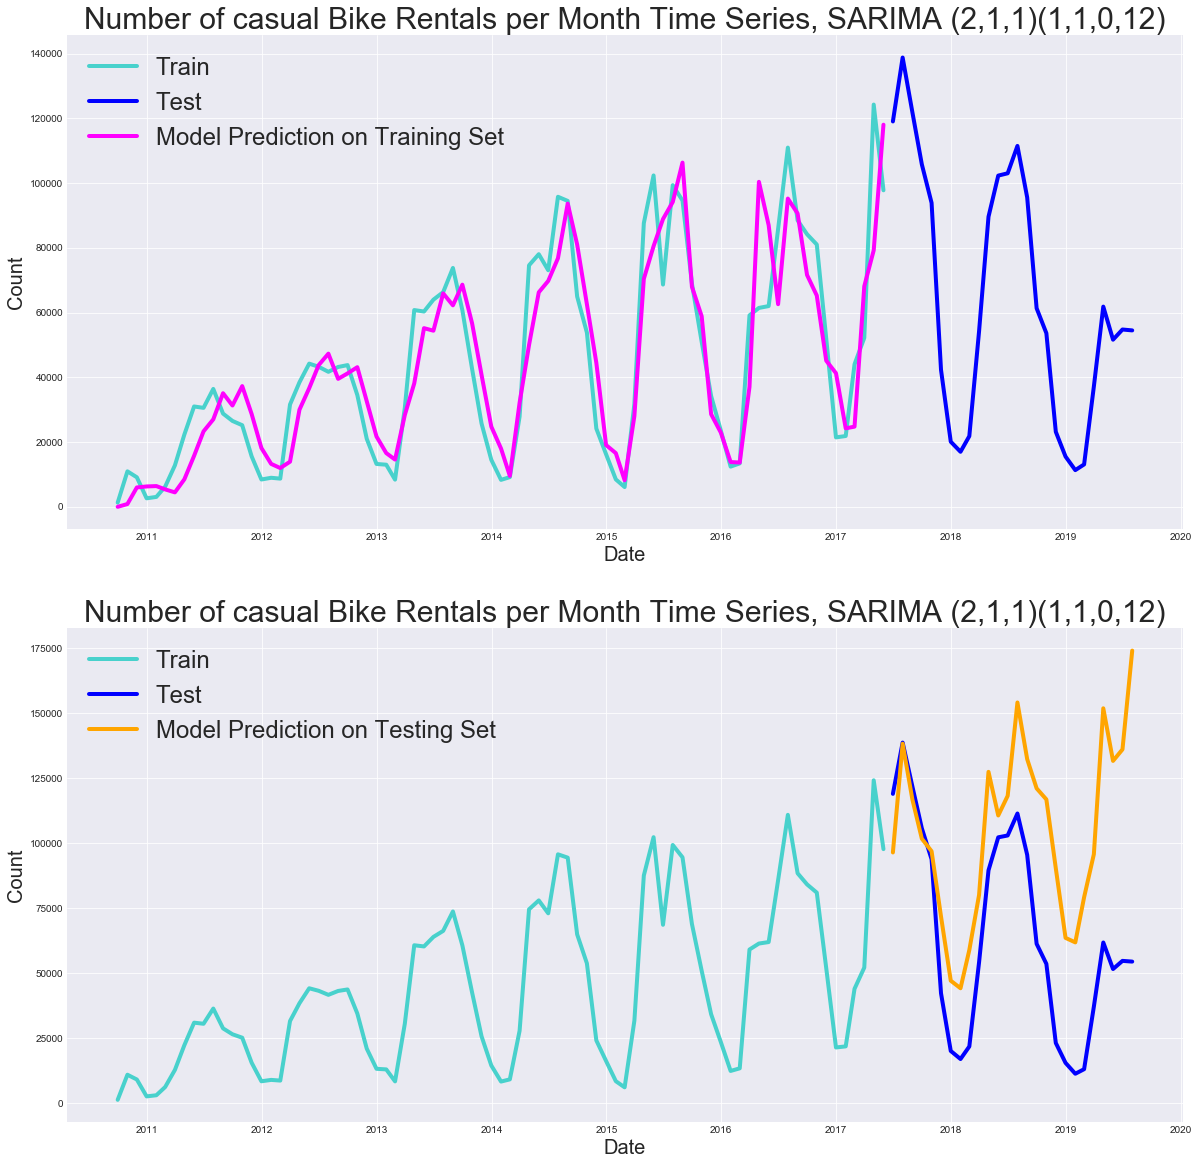

Orders: (2, 1, 1). Seasonal Orders: (0, 1, 1, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -774.568
Date:                            Wed, 30 Oct 2019   AIC                           1559.136
Time:                                    19:07:41   BIC                           1570.234
Sample:                                09-30-2010   HQIC                          1563.533
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5160      0.185     -2.786      0.005      -0.8

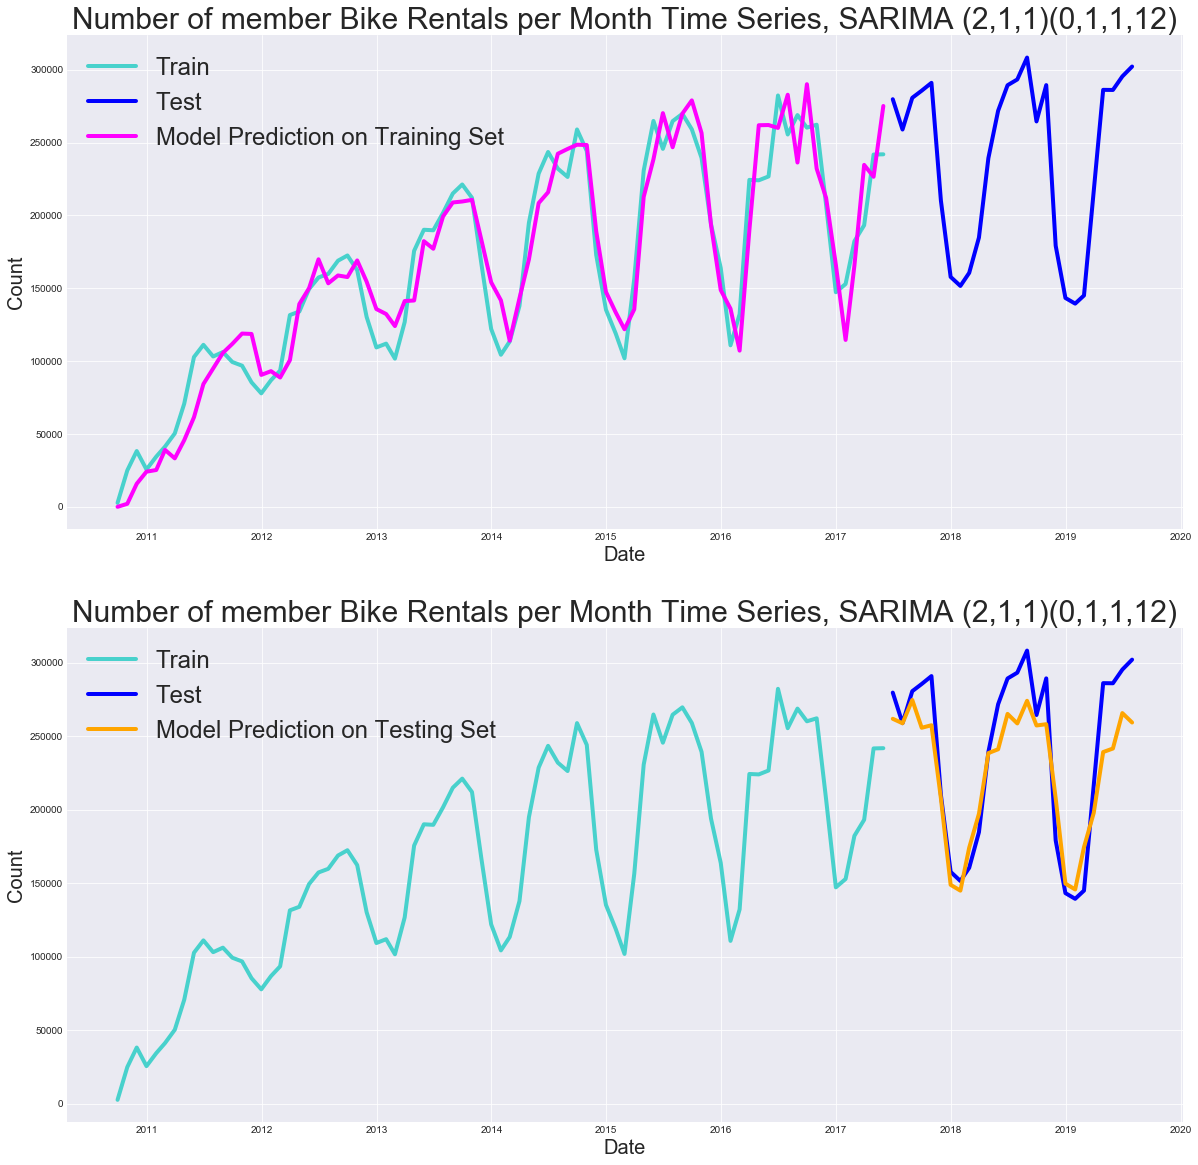

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -748.438
Date:                            Wed, 30 Oct 2019   AIC                           1506.876
Time:                                    19:07:42   BIC                           1517.973
Sample:                                09-30-2010   HQIC                          1511.273
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2589      0.117    -10.795      0.000      -1.487      -1.030
ar.L2         -0.3947      0.118   

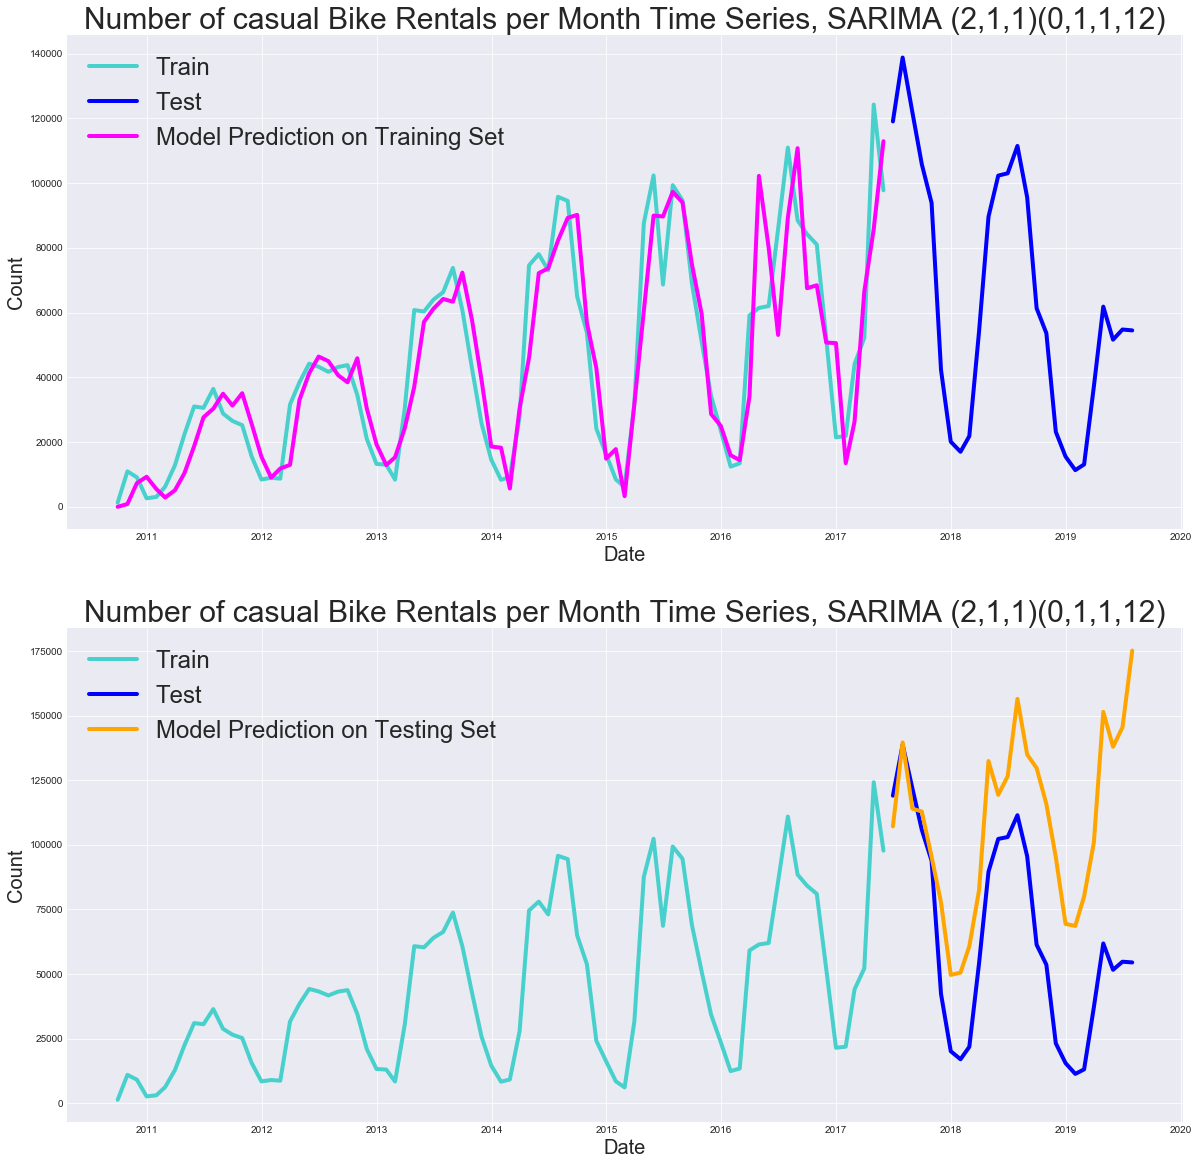

Orders: (2, 1, 2). Seasonal Orders: (0, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -769.483
Date:                            Wed, 30 Oct 2019   AIC                           1548.966
Time:                                    19:07:43   BIC                           1560.064
Sample:                                09-30-2010   HQIC                          1553.363
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4138      0.072     -5.720      0.000      -0.5

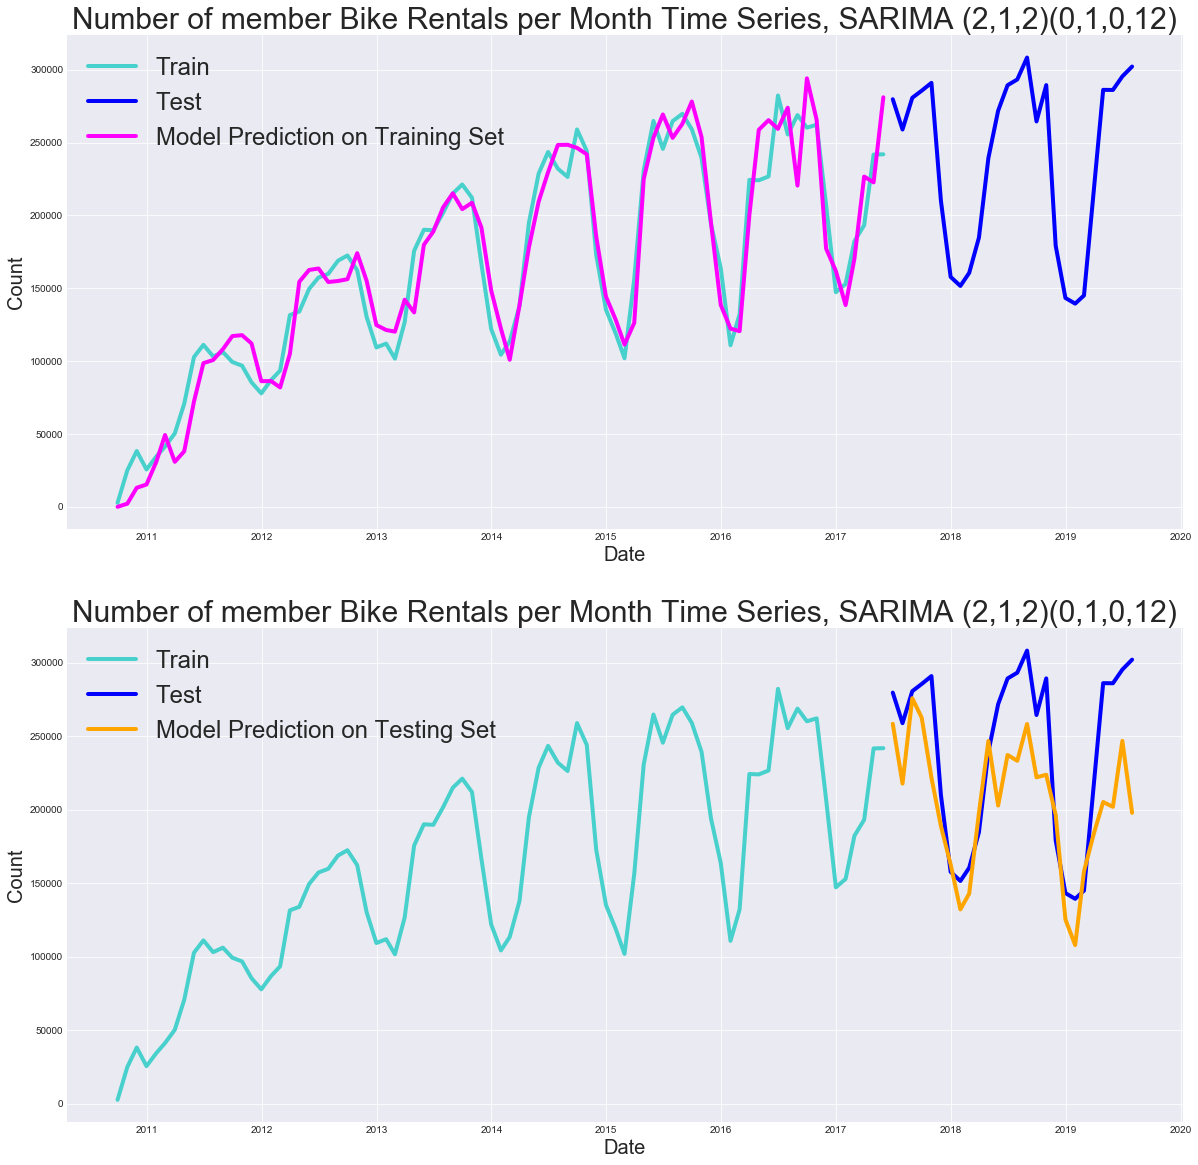

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -747.991
Date:                            Wed, 30 Oct 2019   AIC                           1505.982
Time:                                    19:07:44   BIC                           1517.079
Sample:                                09-30-2010   HQIC                          1510.379
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3841      0.289     -1.327      0.185      -0.951       0.183
ar.L2         -0.6459      0.217   

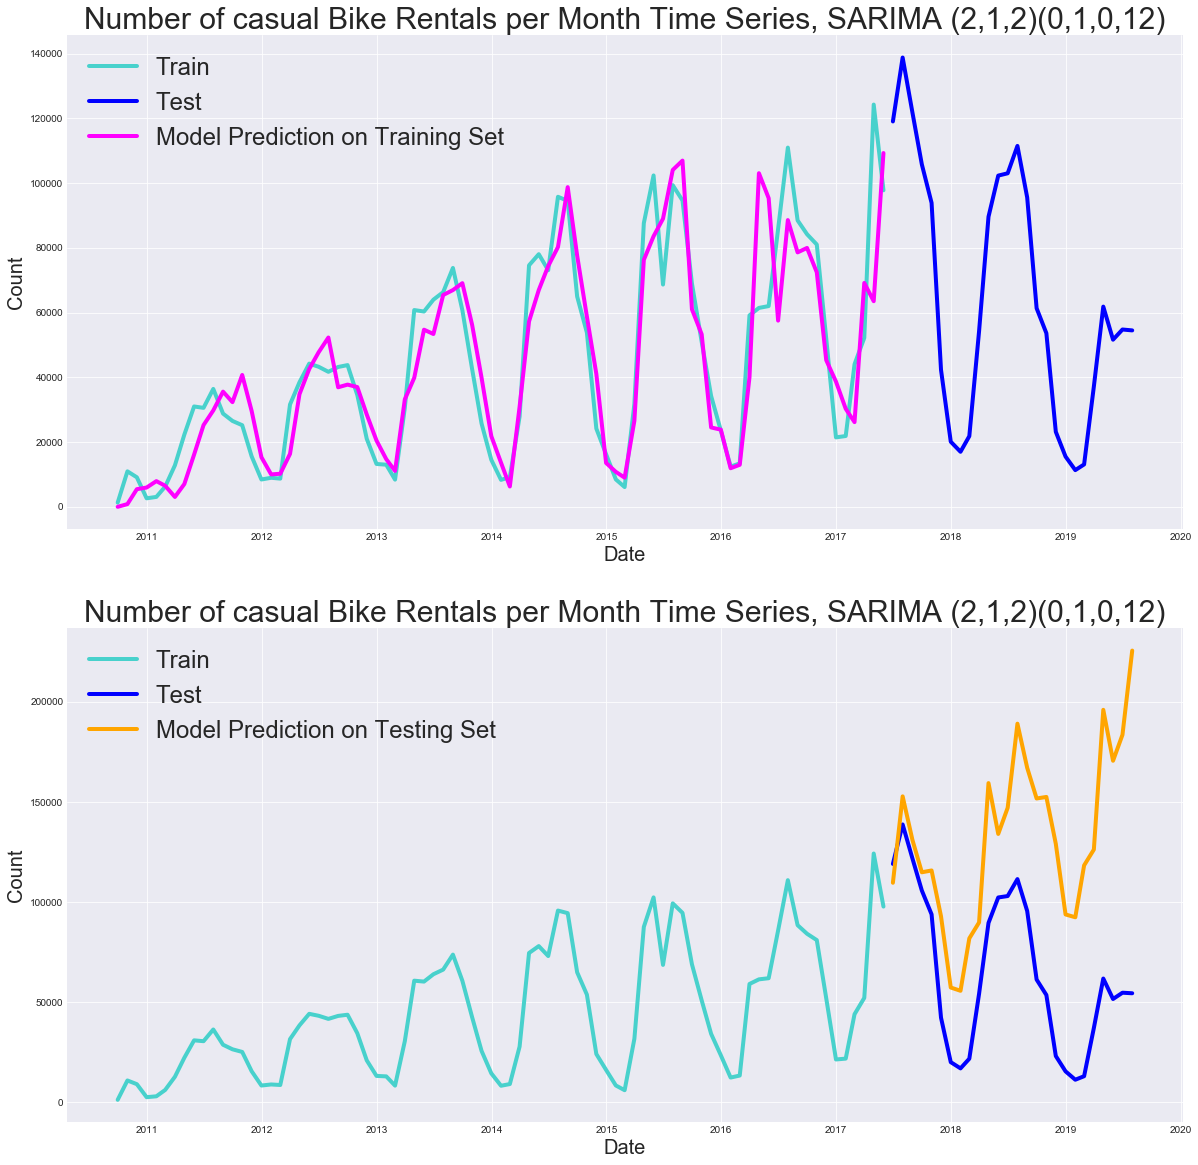

Orders: (2, 1, 2). Seasonal Orders: (1, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -769.483
Date:                            Wed, 30 Oct 2019   AIC                           1550.966
Time:                                    19:07:46   BIC                           1564.283
Sample:                                09-30-2010   HQIC                          1556.243
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4138      0.073     -5.689      0.000      -0.5

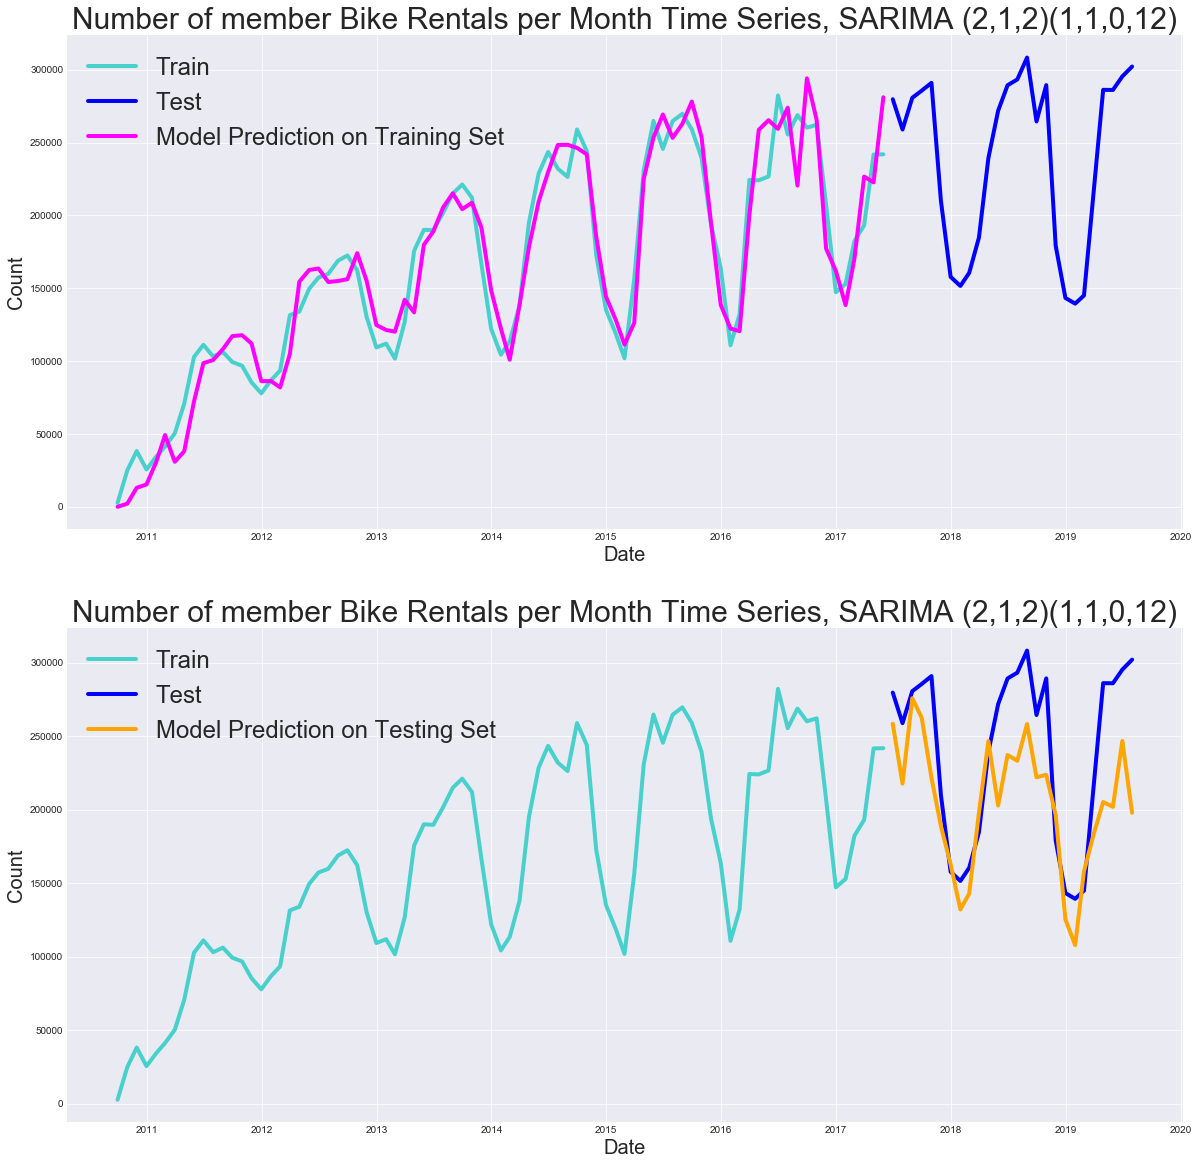

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -744.883
Date:                            Wed, 30 Oct 2019   AIC                           1501.765
Time:                                    19:07:47   BIC                           1515.082
Sample:                                09-30-2010   HQIC                          1507.042
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1528      0.232      0.658      0.511      -0.303       0.608
ar.L2         -0.6274      0.199   

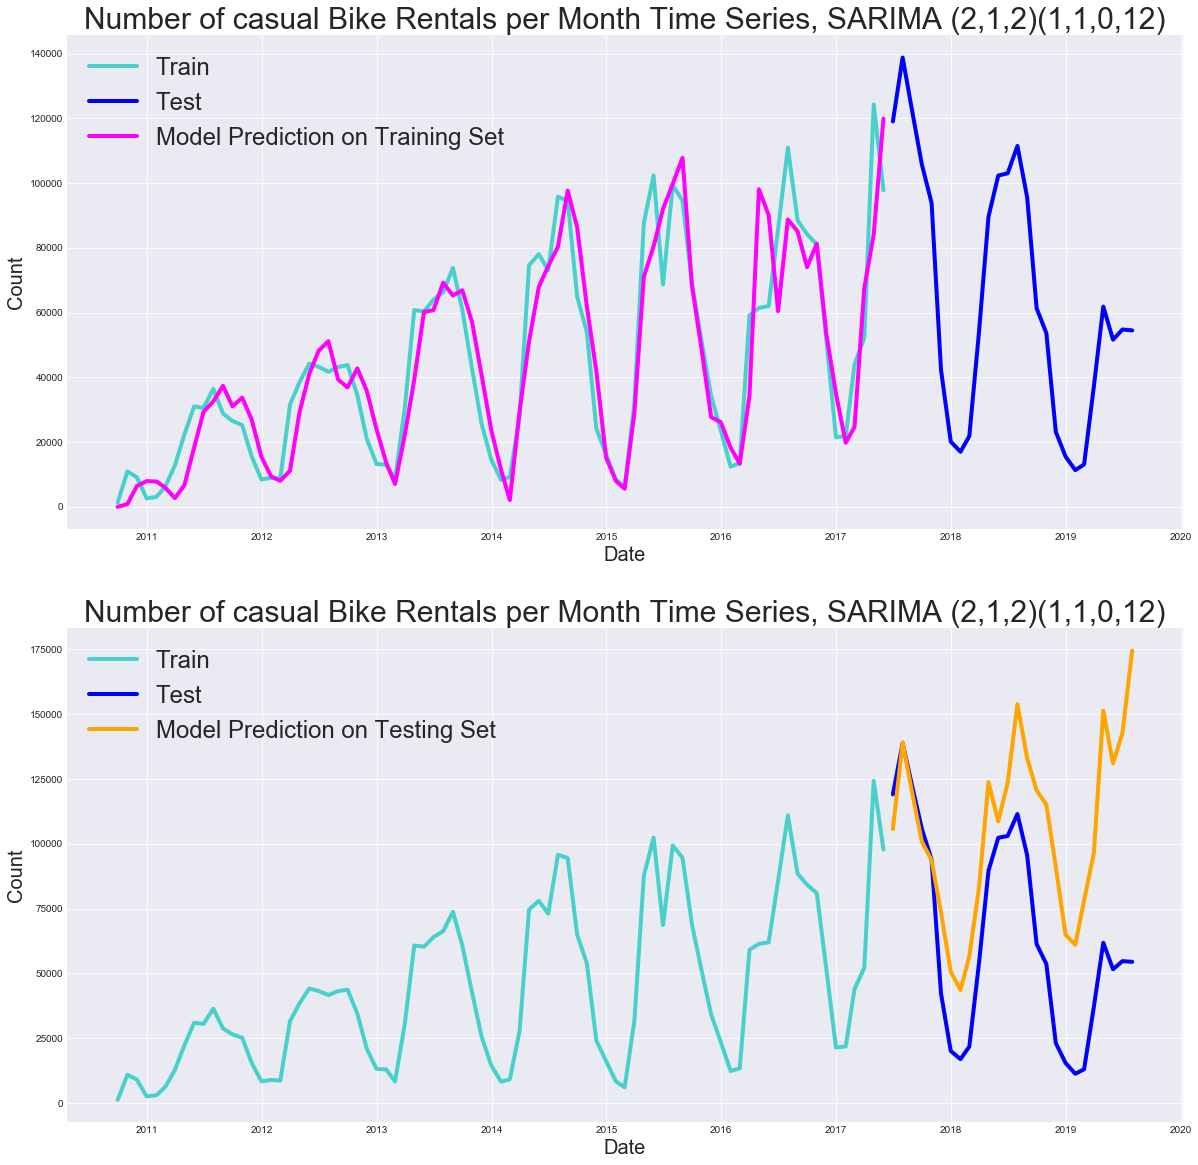

Orders: (2, 1, 2). Seasonal Orders: (0, 1, 1, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -769.483
Date:                            Wed, 30 Oct 2019   AIC                           1550.967
Time:                                    19:07:49   BIC                           1564.284
Sample:                                09-30-2010   HQIC                          1556.243
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4137      0.073     -5.678      0.000      -0.5

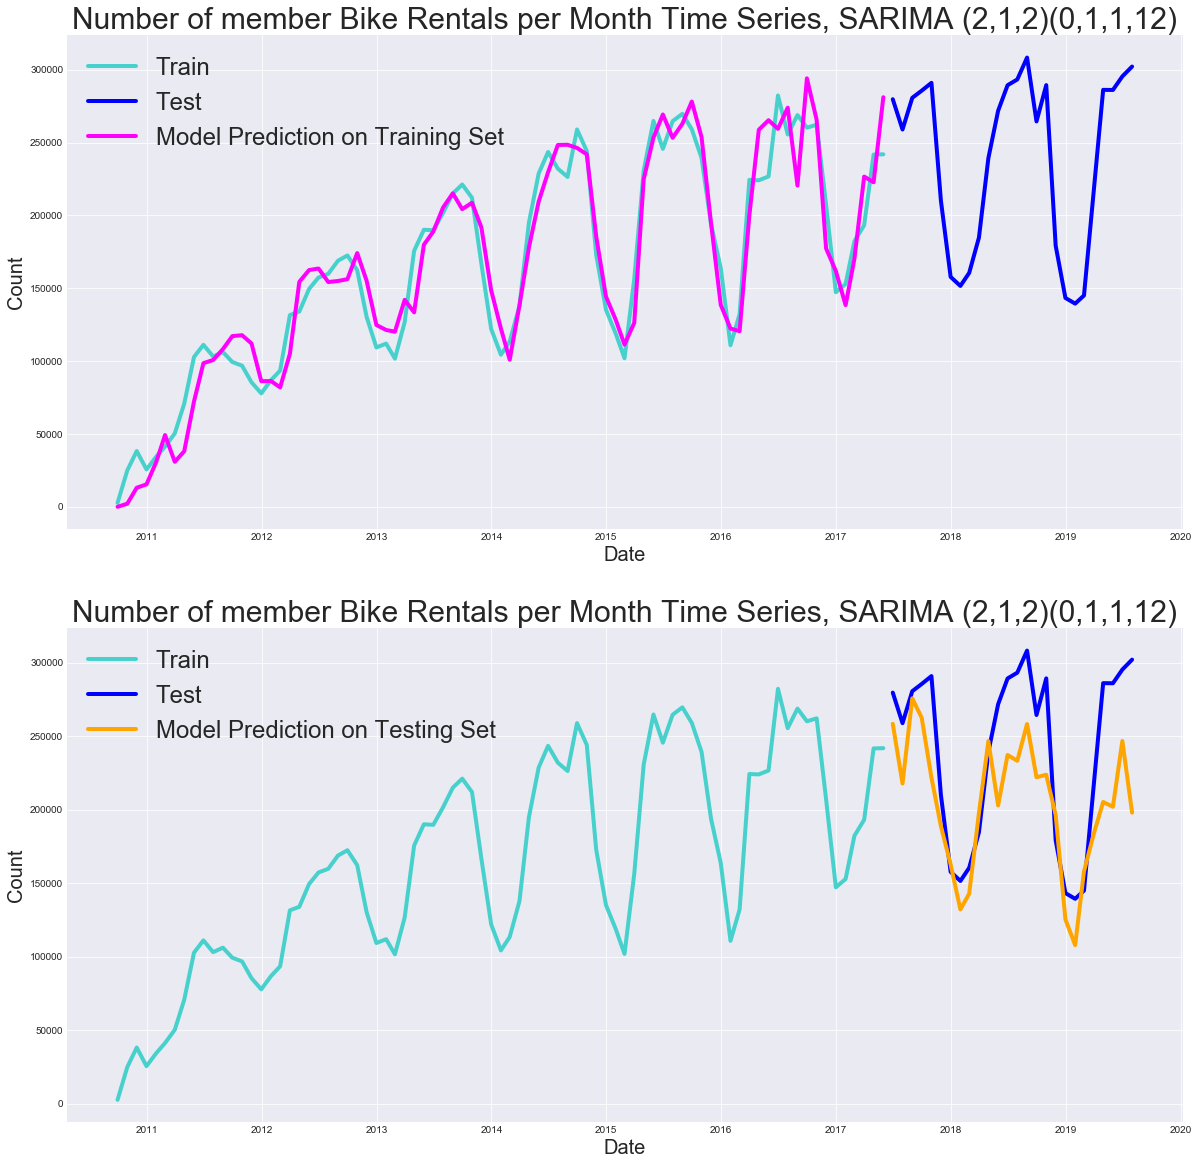

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -745.280
Date:                            Wed, 30 Oct 2019   AIC                           1502.561
Time:                                    19:07:50   BIC                           1515.878
Sample:                                09-30-2010   HQIC                          1507.838
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2131      0.174      1.225      0.220      -0.128       0.554
ar.L2         -0.6201      0.189   

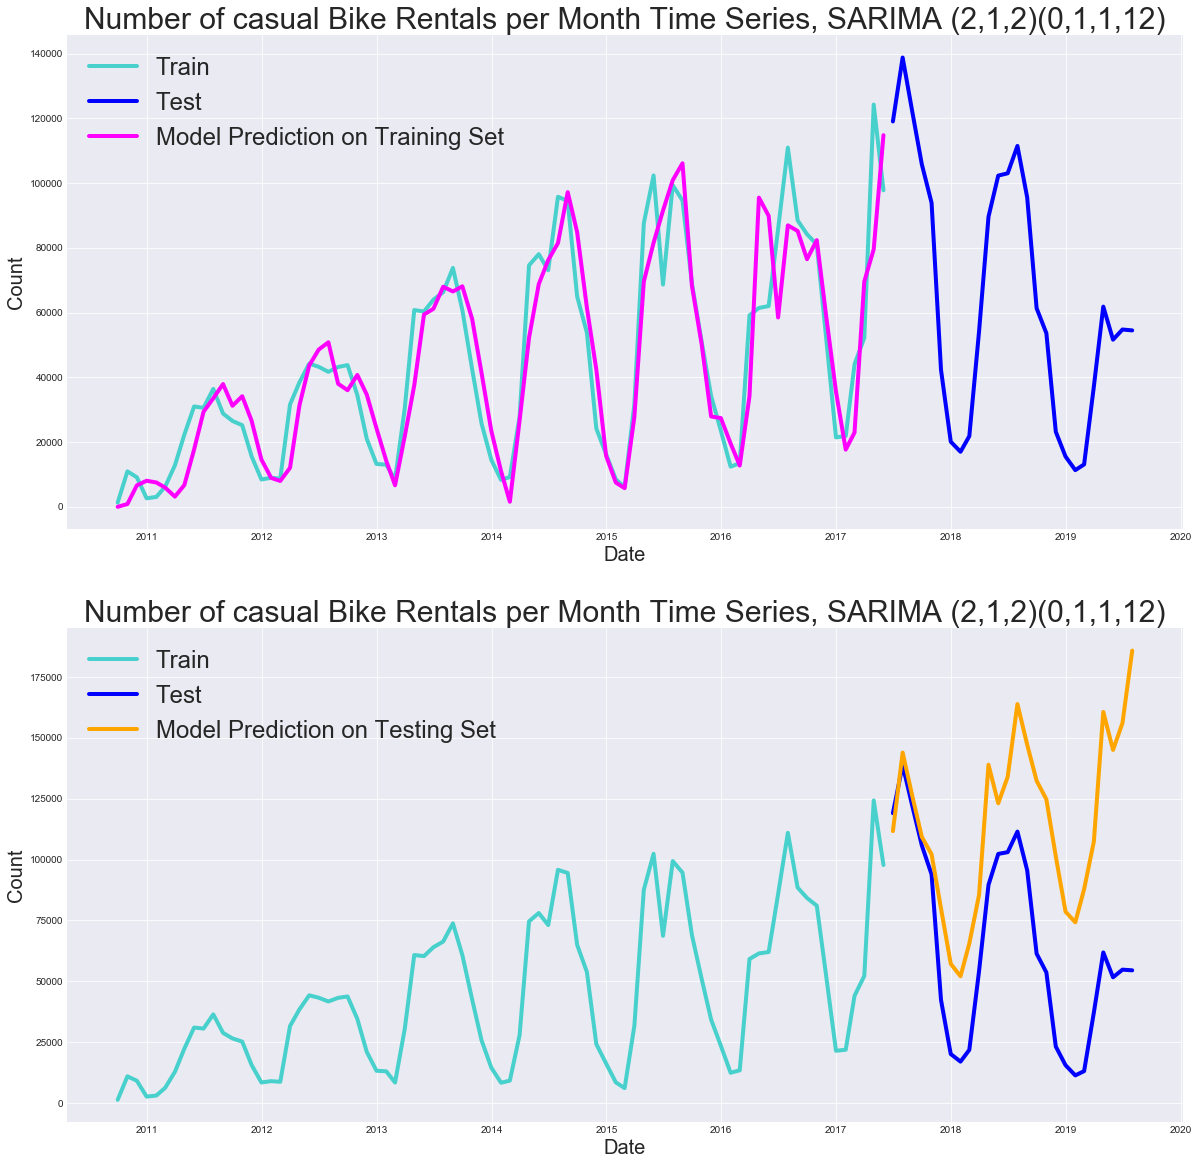

Orders: (2, 1, 3). Seasonal Orders: (0, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood                -767.165
Date:                            Wed, 30 Oct 2019   AIC                           1546.329
Time:                                    19:07:51   BIC                           1559.646
Sample:                                09-30-2010   HQIC                          1551.606
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4914      0.033    -14.808      0.000      -0.5

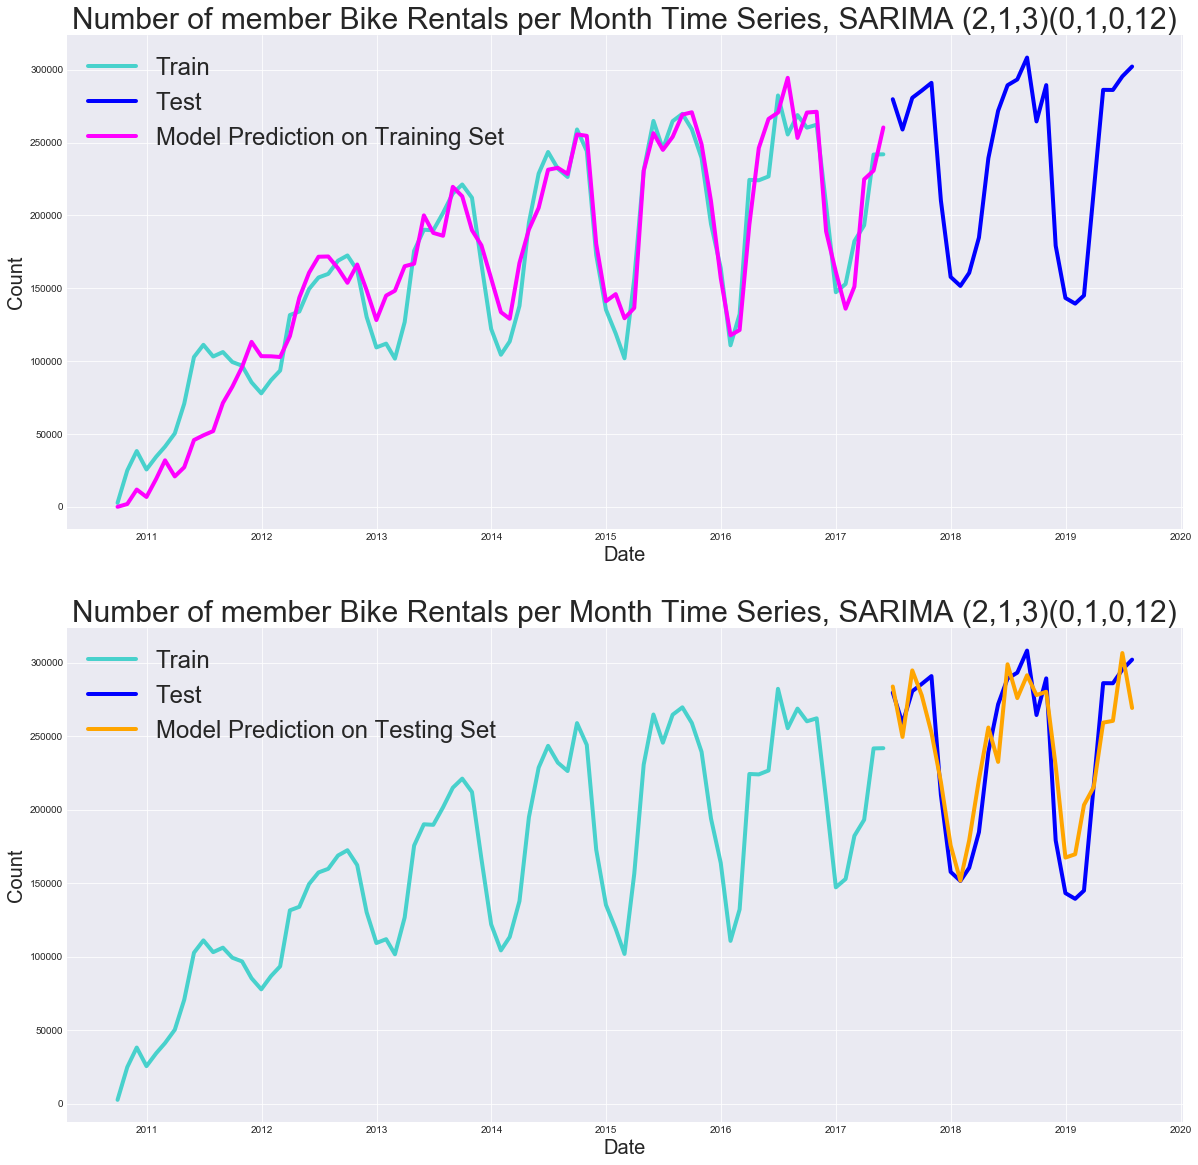

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood                -742.460
Date:                            Wed, 30 Oct 2019   AIC                           1496.921
Time:                                    19:07:53   BIC                           1510.238
Sample:                                09-30-2010   HQIC                          1502.197
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6275      0.116     -5.429      0.000      -0.854      -0.401
ar.L2         -0.9517      0.115   

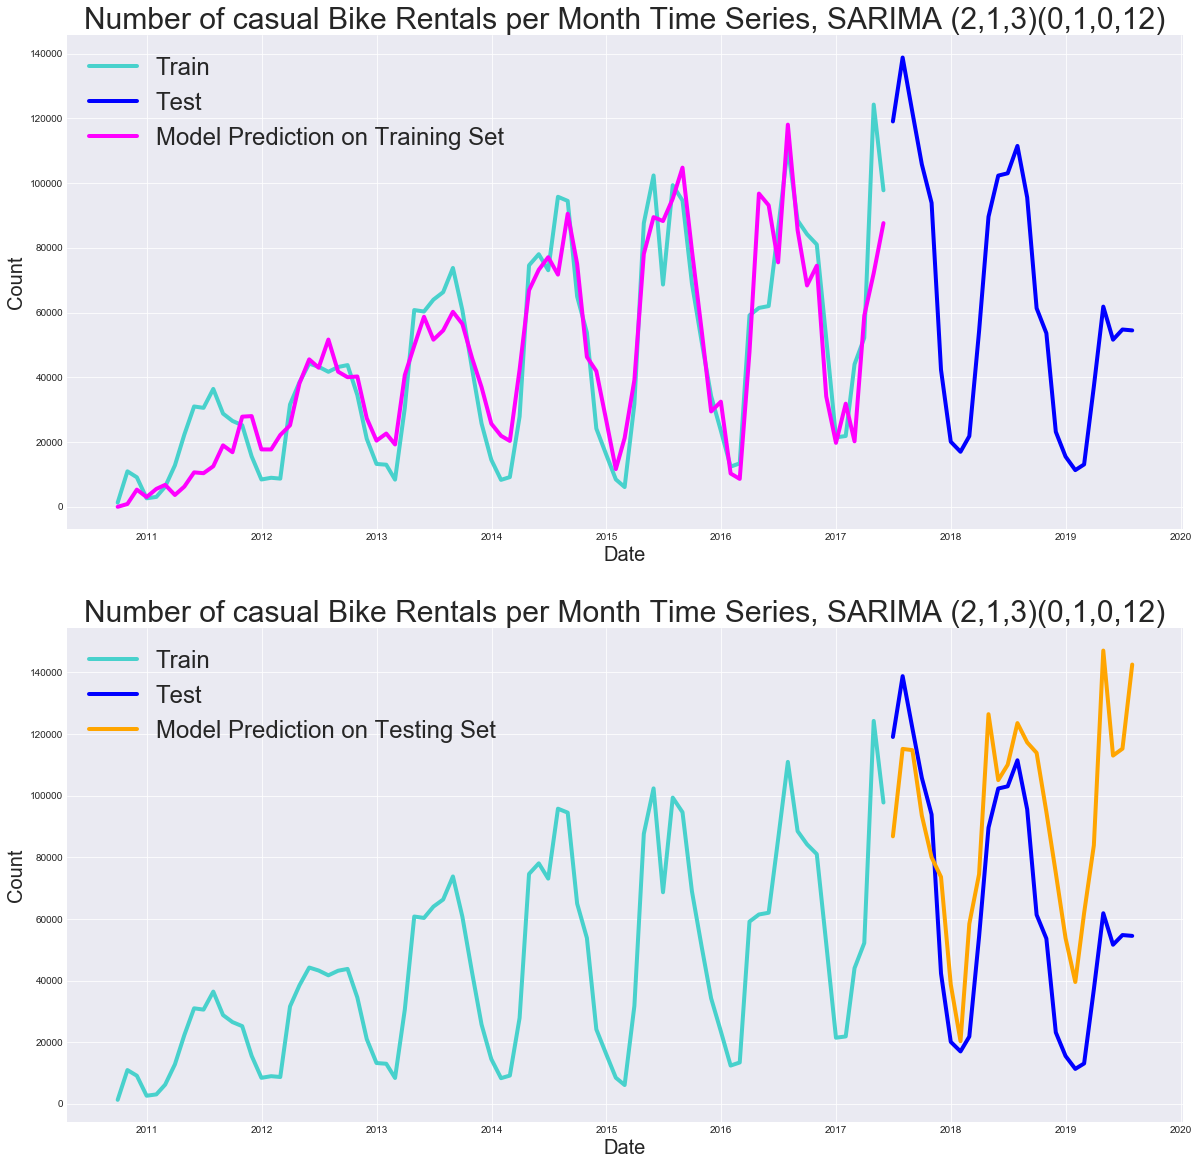

Orders: (2, 1, 3). Seasonal Orders: (1, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -766.735
Date:                            Wed, 30 Oct 2019   AIC                           1547.471
Time:                                    19:07:54   BIC                           1563.007
Sample:                                09-30-2010   HQIC                          1553.627
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4906      0.033    -15.041      0.000      -0.5

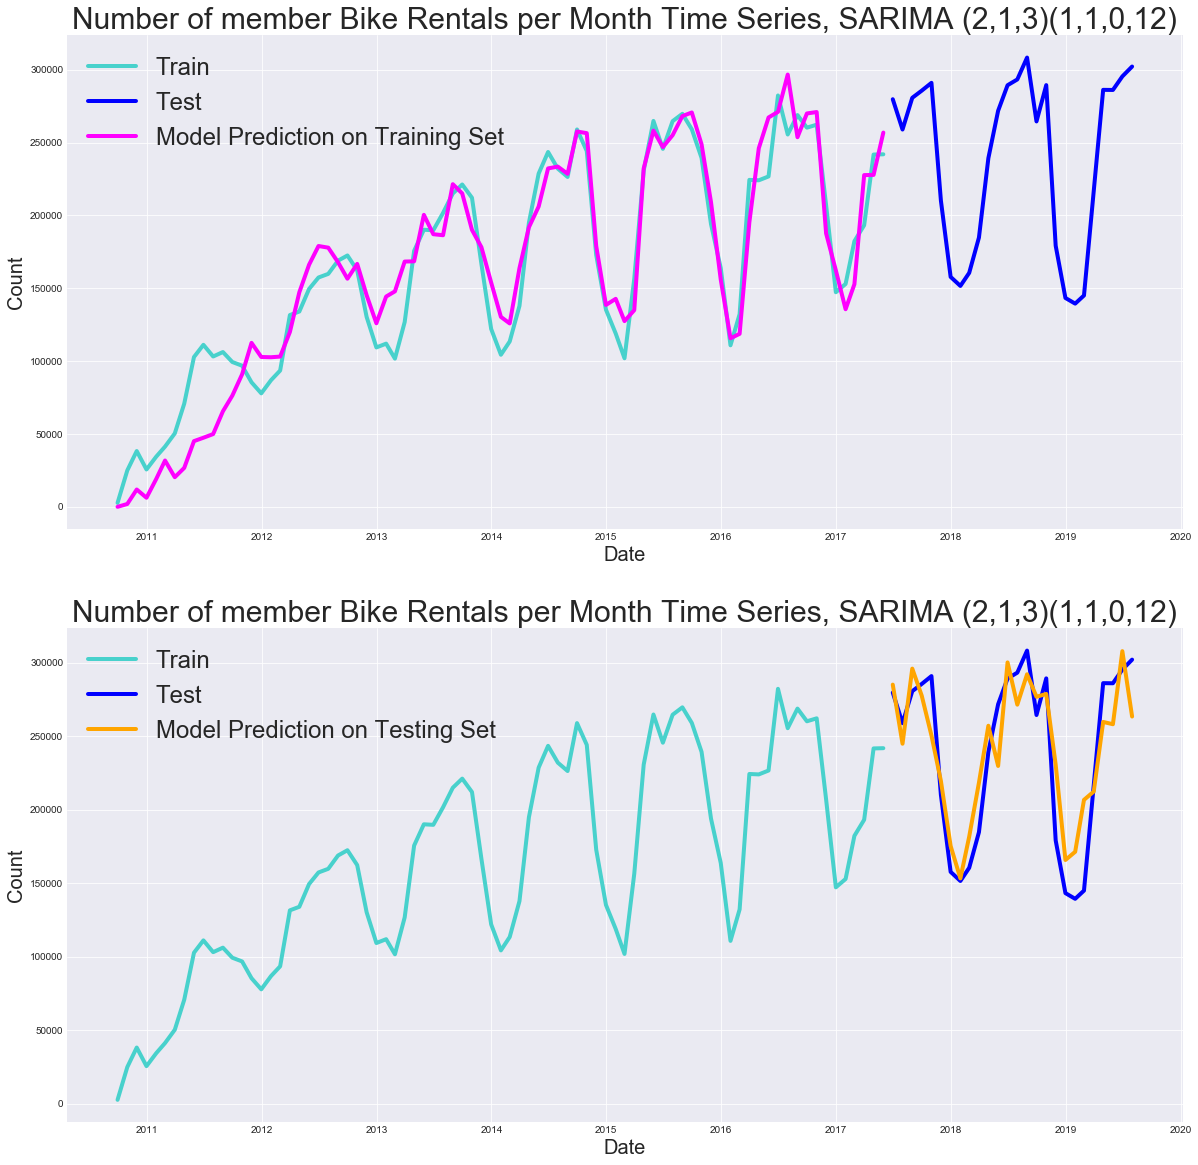

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -742.034
Date:                            Wed, 30 Oct 2019   AIC                           1498.067
Time:                                    19:07:56   BIC                           1513.604
Sample:                                09-30-2010   HQIC                          1504.223
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6332      0.146     -4.333      0.000      -0.920      -0.347
ar.L2         -0.9262      0.146   

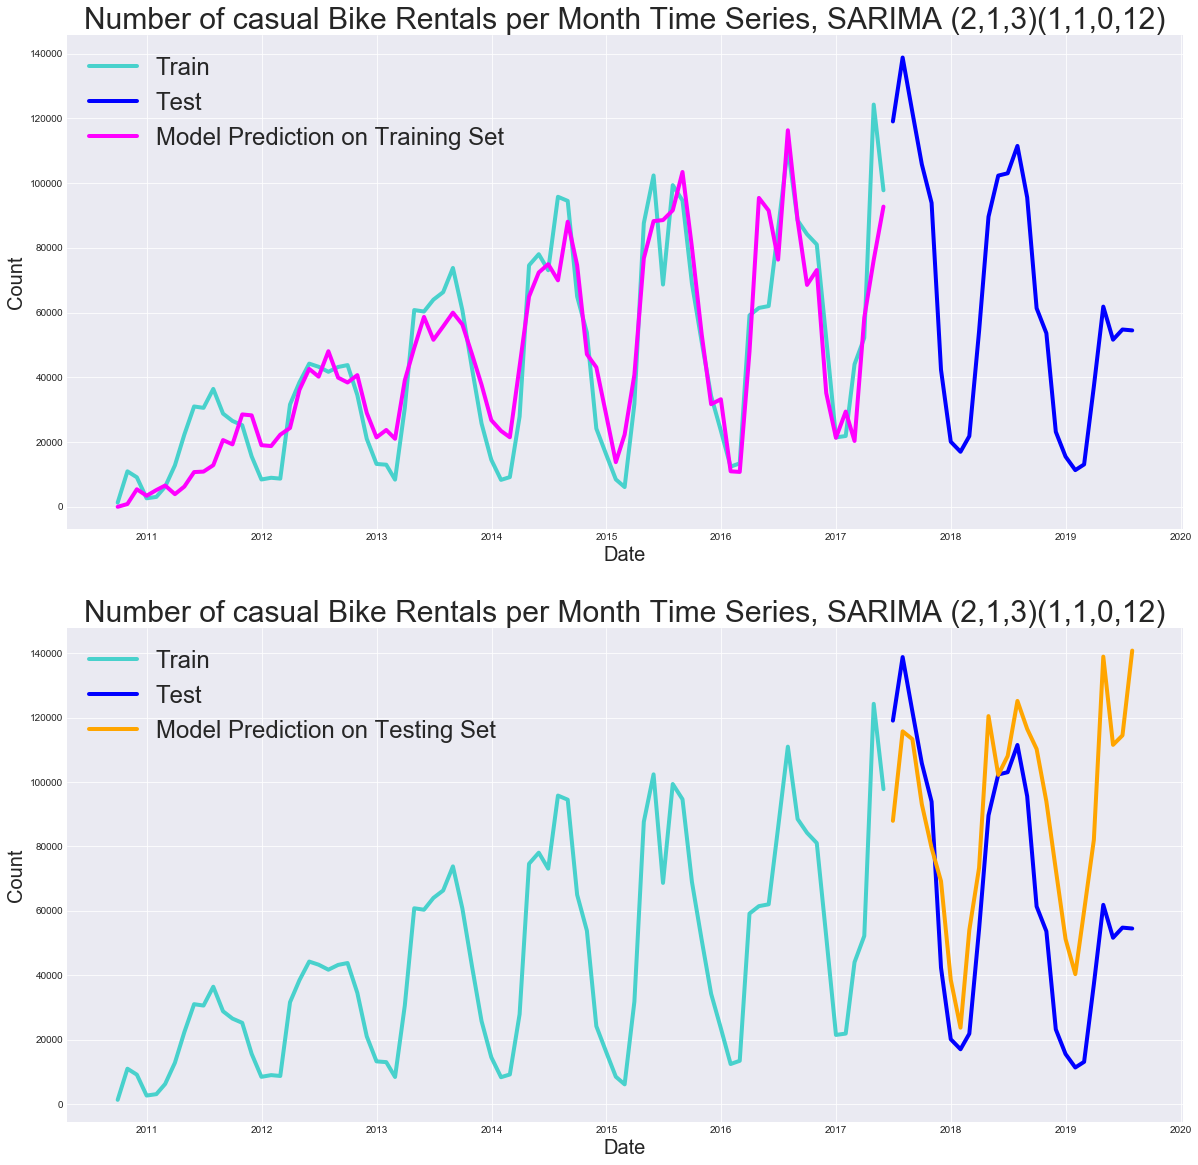

Orders: (2, 1, 3). Seasonal Orders: (0, 1, 1, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -766.604
Date:                            Wed, 30 Oct 2019   AIC                           1547.208
Time:                                    19:07:58   BIC                           1562.744
Sample:                                09-30-2010   HQIC                          1553.364
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4911      0.032    -15.184      0.000      -0.5

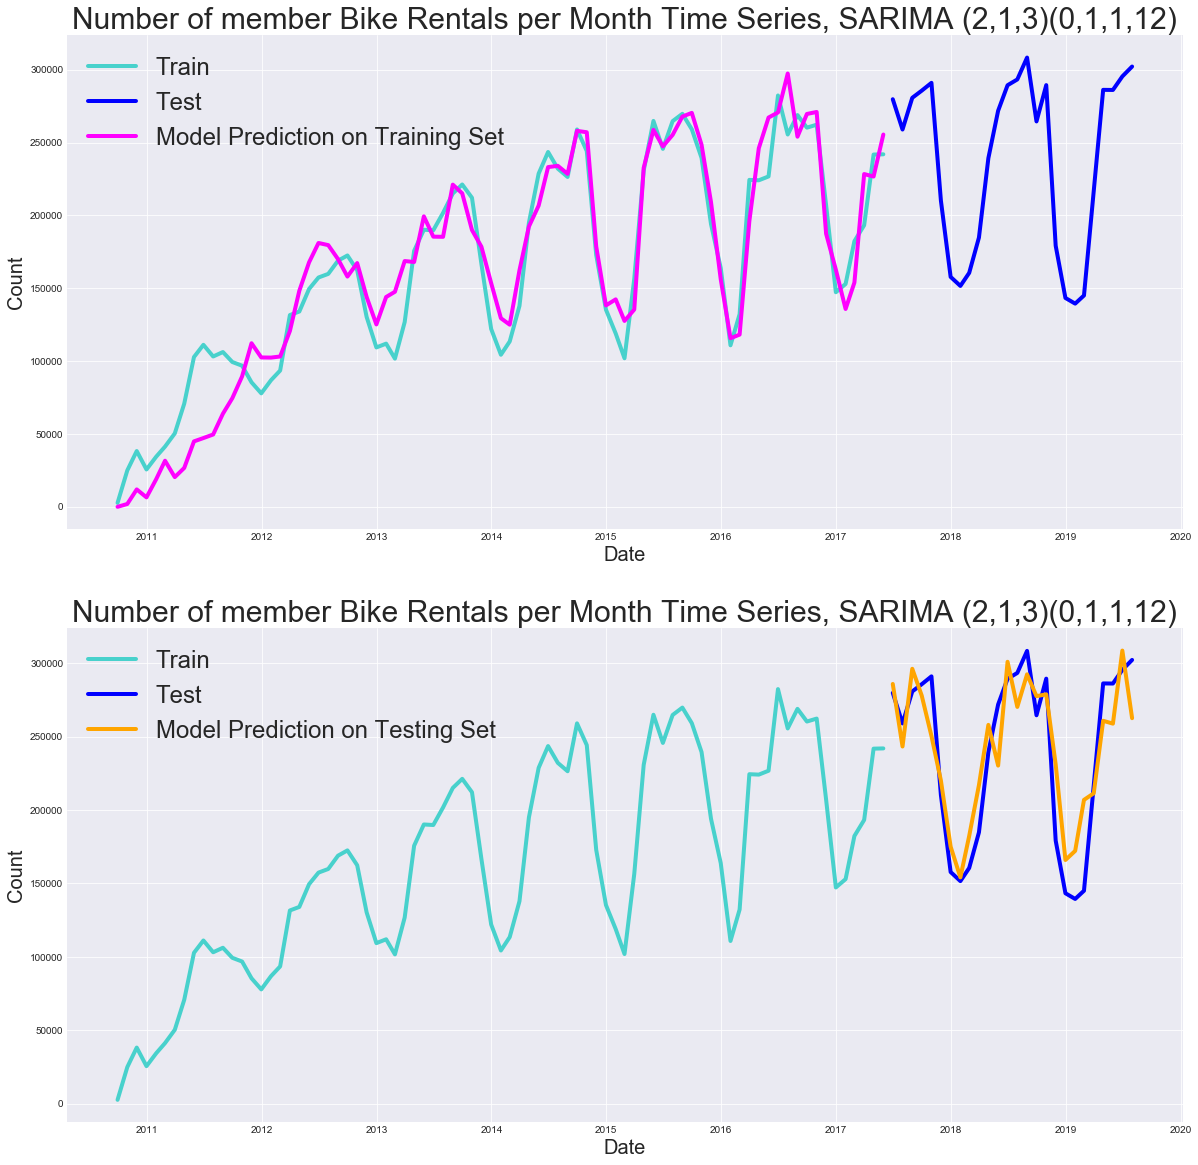

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -745.053
Date:                            Wed, 30 Oct 2019   AIC                           1504.106
Time:                                    19:08:00   BIC                           1519.642
Sample:                                09-30-2010   HQIC                          1510.262
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1643      0.265      0.620      0.535      -0.355       0.684
ar.L2         -0.6002      0.233   

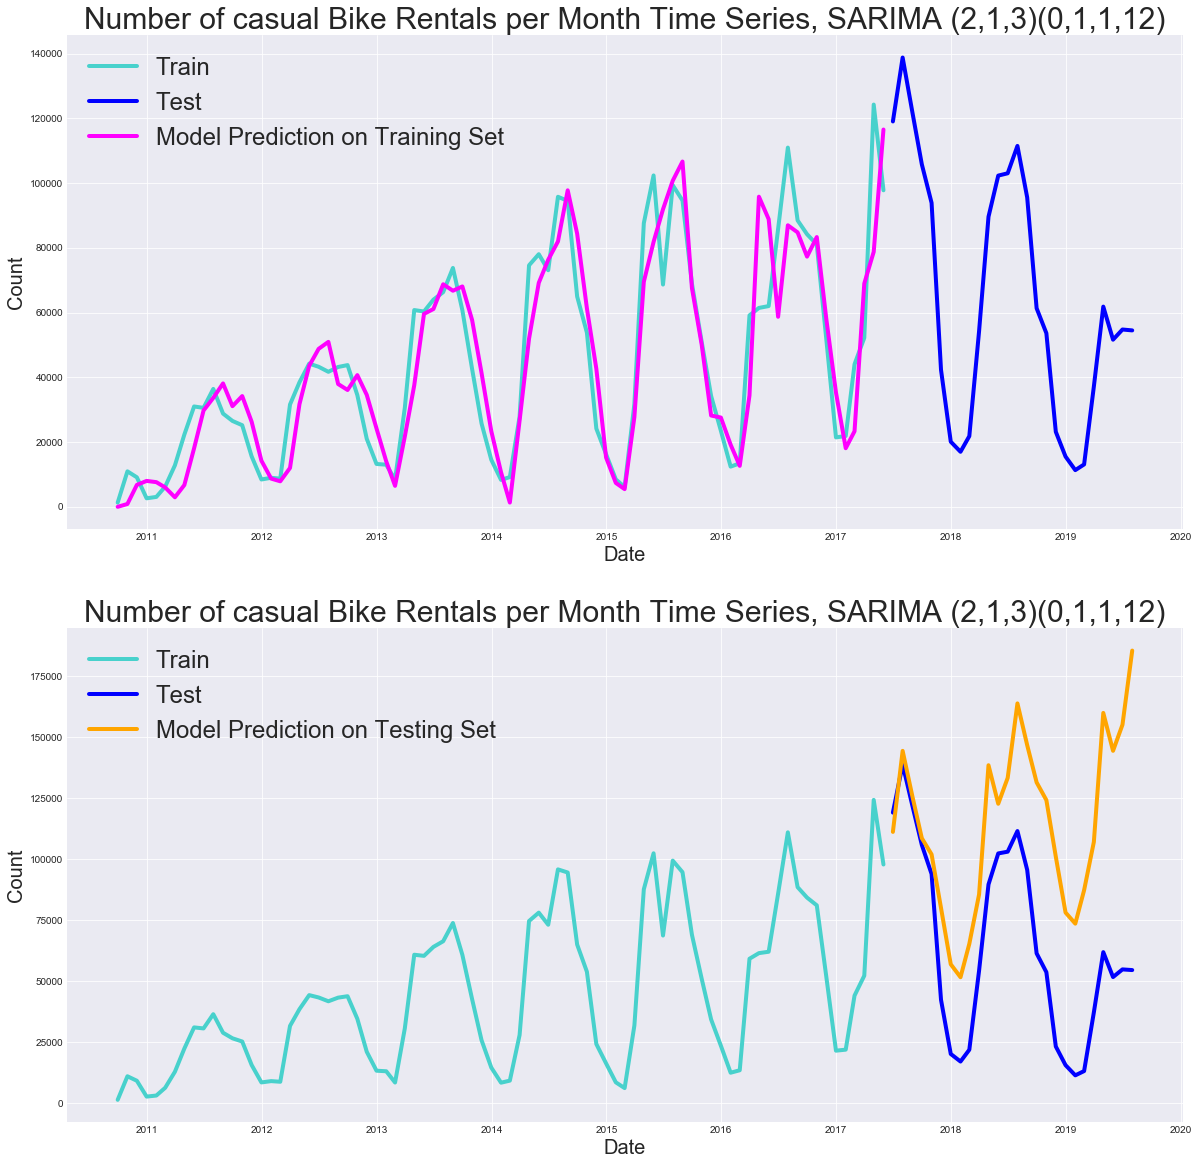

In [23]:
dt.sarima_breakdown(breakdown_train, breakdown_test)

We can get good fit for the member data, but the casual use data has a sudden recent dip in rentals, which is hard to build a time series model on without more data. We will try with (2,1,3) (0,1,0,12) for Members and (2,1,2)(0,1,1,12) for Casual rides.

In [24]:
members_213_01012 = sm.tsa.statespace.SARIMAX(bike_rental_type['member'], order=(2, 1, 3),
                                              seasonal_order=(0, 1, 0, 12)).fit()
members_213_01012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                  107
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood               -1064.549
Date:                            Wed, 30 Oct 2019   AIC                           2141.097
Time:                                    19:08:01   BIC                           2156.357
Sample:                                09-30-2010   HQIC                          2147.261
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5220      0.036    -14.378      0.000      -0.593      -0.451
ar.L2         -0.9622      0.046    -20.914      0.000      -1.052      -0.872
ma.L1         -0.1963      0.075     -2.613      0.009      -0.344      -0.049
ma.L2          0.4205      0.118      3.557      0.000       0.189       0.652
ma.L3         -0.8415      0.143     -5.881      0.000      -1.122      -0.561
sigma2      4.607e+08    1.2e-10   3.84e+18      0.000    4.61e+08    4.61e+08
===================================================================================
Ljung-Box (Q):                       79.71   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.00   Prob(JB):                         0.72
Heteroskedasticity (H):               1.23   Skew:                             0.06
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+35. Standard errors may be unstable.
"""

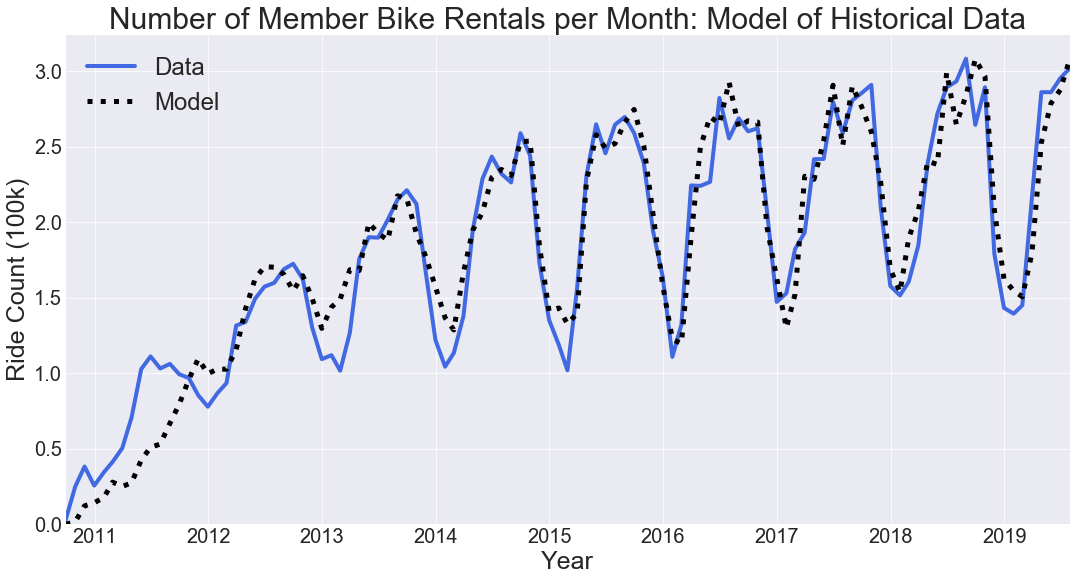

In [25]:
p.model_plot_breakdown(members_213_01012, bike_rental_type, kind='Member')

In [26]:
casual_212_01112 = sm.tsa.statespace.SARIMAX(bike_rental_type['casual'], order=(2, 1, 2),
                                             seasonal_order=(0, 1, 1, 12)).fit()
casual_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             casual   No. Observations:                  107
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1029.449
Date:                            Wed, 30 Oct 2019   AIC                           2070.898
Time:                                    19:08:02   BIC                           2086.158
Sample:                                09-30-2010   HQIC                          2077.062
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3905      0.184      2.118      0.034       0.029       0.752
ar.L2         -0.6174      0.204     -3.033      0.002      -1.016      -0.218
ma.L1         -0.6917      0.131     -5.279      0.000      -0.949      -0.435
ma.L2          0.8461      0.134      6.328      0.000       0.584       1.108
ma.S.L12      -0.5175      0.120     -4.313      0.000      -0.753      -0.282
sigma2       2.47e+08    3.9e-10   6.33e+17      0.000    2.47e+08    2.47e+08
===================================================================================
Ljung-Box (Q):                       45.66   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.25   Prob(JB):                         0.19
Heteroskedasticity (H):               2.15   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.55e+33. Standard errors may be unstable.
"""

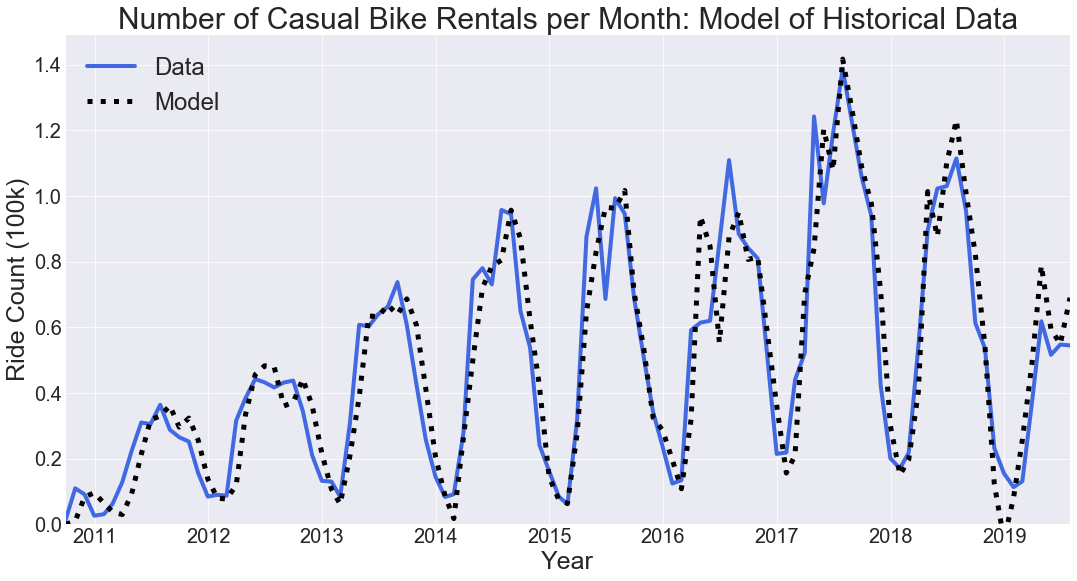

In [27]:
p.model_plot_breakdown(casual_212_01112, bike_rental_type, kind='Casual')

As you can see, the p-values of both are very low, indicating a close correlation between the models and the actual data. In addition, we can see a very clear difference in volume between member and casual rentals.

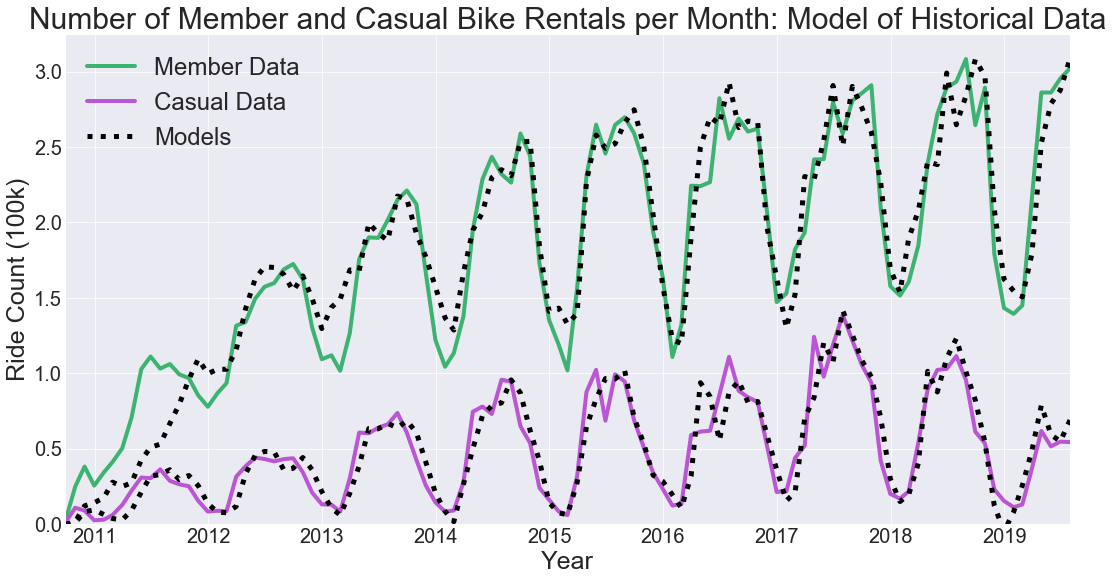

In [28]:
p.model_plot_breakdown_both(
    members_213_01012, casual_212_01112, bike_rental_type)

Now, we will conduct forecasts for both datasets.

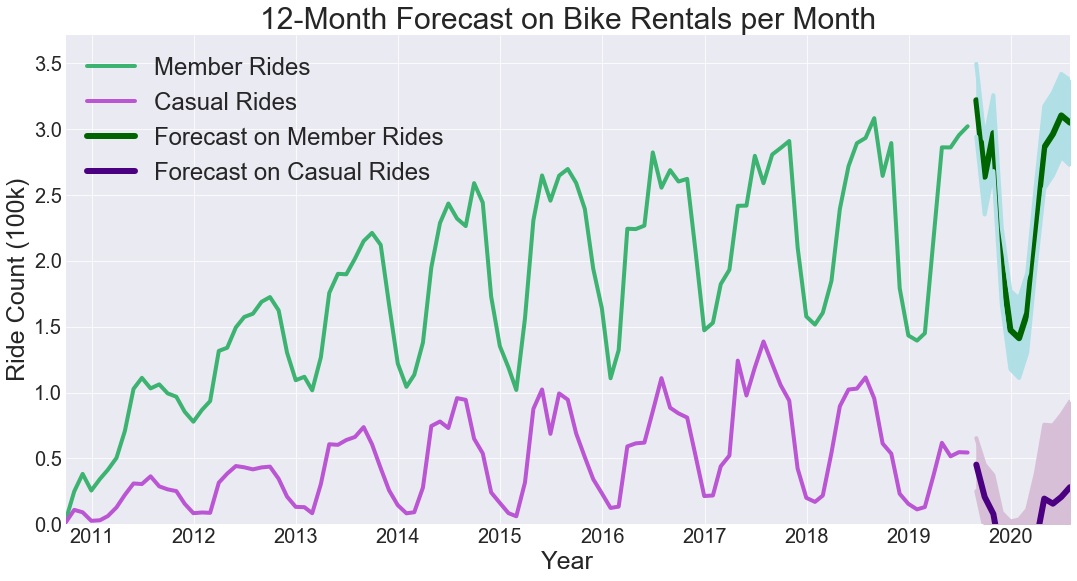

In [29]:
p.forecast_plot_breakdown_both(
    members_213_01012, casual_212_01112, bike_rental_type, 12)

As we can see, the size of the prediction interval shrinks for the member rentals, and the prediction appears to level out. This indicates that, while the usage is not projected to increase  substantially for members, it is not projected to decrease  substantially either. However, for the casual riders, we see that the predicted usage drops below zero. This is an indicator that the time series, as it is, is still too random to provide stable predictions for this part of the dataset. The industry for casual usage, however, does appear to be in decline.

Based on this prediction, since bicycle usage is not projected to increase substantially in the next year, we can determine that Capital Bikeshare has a sufficient number of bicycles to operate over the next 12 months.